<h1><center> Defi-IA 2022 </center></h1>
<h5><center>Goal : predict the accumulated daily rainfall on ground stations.</center></h5>
<center>
      <br> Florian Lajugie     -     Martin Magnan     -     Eva Membrado     -     Yannick Selly     -     Benjamin Viard 
</center>

# 1. Introduction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
from scipy.special import expit
from scipy import spatial
import xarray as xr
import os
import pandas as pd 
import gc

from datetime import date
import dateutil.relativedelta
import matplotlib.dates
from numpy import genfromtxt
import csv

In [ ]:
import tensorflow.keras as keras
from keras.models import Model, load_model
from keras.layers import Input,ConvLSTM2D,TimeDistributed,Concatenate,Add,Bidirectional,Concatenate, dot, add, multiply, \
           Activation, Reshape, Dense, RepeatVector, Dropout, Permute, LSTM, Dense, Flatten, Embedding
from keras.layers.convolutional import Conv3D,Conv2D,SeparableConv2D, Cropping2D, Cropping3D,Conv2DTranspose, UpSampling2D, DepthwiseConv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.layers import Lambda
from keras import backend as K
from keras.backend import sum
from keras import initializers as KI
import tensorflow as tf

In [ ]:
pip list

In [ ]:
path = '/content/drive/My Drive/INSA_stat/Défi_IA/'

# 2. Mise en forme des données

<u>Importation des coordonnées de toutes les stations de mesure.

In [ ]:
data = genfromtxt(path+'data_kaggle/stations_coordinates.csv', delimiter=',', skip_header = 1)
coordonnees_stations = data[:,1:3]
numéros_stations = data[:,0]
altitude_stations = data[:,-1]

print("coordonnees_stations.shape :",coordonnees_stations.shape)
print(coordonnees_stations[0])

coordonnees_stations.shape : (325, 2)
[46.477  0.985]


In [ ]:
journées_train = pd.date_range(start="2016-01-01", end="2017-12-31")
liste_journées_train = np.array(str(journées_train[0])[:10],dtype =str)
for i in range(1,len(journées_train)):
    liste_journées_train = np.append(liste_journées_train,str(journées_train[i])[:10])
journées_train = liste_journées_train
journées_train

In [ ]:
journées_test = [i for i in range(363)]

In [ ]:
id_month_test = genfromtxt(path+'data_kaggle/Id_month_test.csv', delimiter=',', skip_header = 1)

## 2.1. X_forecast

A partir du tenseur des prévisions du modèle AROME pour notre domaine d'étude spatial, sur une période de temps considérée, pour les $7$ prédicteurs étudiées, au format : (nb_jours, nb_heures, latitudes, longitudes, nb_prédicteurs), on va produire un tenseur des prévisions modèle interpolées sur les coordonnées de nos $325$ stations de mesures, afin de pouvoir faire des prévisions locales par station de mesure avec notre réseau de neurones. Le format de ce nouveau tenseur sera : (nb_jours, nb_stations, nb_heures, nb_prédicteurs).

In [ ]:
def X_forecast_jour(ds):
    # Conversion des prévisions modèle du format xarray.Dataset au format numpy.
    ds_np = np.delete(np.array((ds['u10'], ds['v10'], ds['t2m'], ds['d2m'], ds['r'], ds['tp'], ds['msl'])), 0, axis=1)
    
    # Redimensionnement du tenseur des prévisions modèle.
    prévisions_modèle = np.zeros((ds_np.shape[1], ds_np.shape[2], ds_np.shape[3], ds_np.shape[0]))
    for i in range(ds_np.shape[0]):
      prévisions_modèle[:,:,:,i] = ds_np[i,:,:,:]
    
    # Fonction qui renvoie à partir des coordonnées d'une station de mesure, les coordonnées des points de grille 
    # du modèle AROME qui encadrent la station, ainsi que l'indice dans la liste des prévisions modèle de ces points de grille.
    def chgt_base(point):
      x, y = point[0], point[1]

      z1 = (51.896 - x)/0.025
      ind_lat_inf, ind_lat_sup = int(z1), int(z1)+1
      lat_inf, lat_sup = np.round(51.896 - ind_lat_inf*0.025,3) , np.round(51.896 - ind_lat_sup*0.025, 3)

      z2 = (y + 5.842)/0.025
      ind_long_inf, ind_long_sup = int(z2), int(z2)+1
      long_inf, long_sup = np.round(-5.842 + ind_long_inf*0.025,3) , np.round(-5.842 + ind_long_sup*0.025, 3)

      return [[ind_lat_inf, lat_inf], [ind_lat_sup, lat_sup], [ind_long_inf, long_inf], [ind_long_sup, long_sup]]
    
    prévisions_stations = np.zeros((len(coordonnees_stations), prévisions_modèle.shape[0], prévisions_modèle.shape[-1]))
    
    # Création du tenseur des prévisions modèle interpolées sur les stations de mesure.
    for space in range(len(coordonnees_stations)):
      L = chgt_base(coordonnees_stations[space])

      coord_NO = [L[0][1],L[2][1]]
      coord_NE = [L[0][1],L[3][1]]
      coord_SO = [L[1][1],L[2][1]]
      coord_SE = [L[1][1],L[3][1]]

      tree = spatial.KDTree([(coordonnees_stations[space,0], coordonnees_stations[space,1])])
      dist_NO = tree.query(coord_NO)[0]
      dist_NE = tree.query(coord_NE)[0]
      dist_SO = tree.query(coord_SO)[0]
      dist_SE = tree.query(coord_SE)[0]

      s = 1/dist_NO**2 + 1/dist_NE**2 + 1/dist_SO**2 + 1/dist_SE**2

      for time in range(prévisions_modèle.shape[0]):
        for pred in range(prévisions_modèle.shape[-1]):
          prev_NO = prévisions_modèle[time, L[0][0], L[2][0], pred]
          prev_NE = prévisions_modèle[time, L[0][0], L[3][0], pred]
          prev_SO = prévisions_modèle[time, L[1][0], L[2][0], pred]
          prev_SE = prévisions_modèle[time, L[1][0], L[3][0], pred]

          prev = (prev_NO/dist_NO**2 + prev_NE/dist_NE**2 + prev_SO/dist_SO**2 + prev_SE/dist_SE**2) / s

          prévisions_stations[space, time, pred] = prev
    
    return prévisions_stations

In [ ]:
# fonction qui traite les fichiers X_forecast.nc du modèle 2D_arome et qui les convertit en un np.array de la forme :
# (nb_jours, nb_stations, nb_heures, nb_prédicteurs)

def X_forecast(journées):
    X_forecast = np.zeros(((1,len(numéros_stations),24,7)))
    for i in range(len(journées)):
        ############# train
        journee = journées[i]
        fichier = journee[:4]+journee[5:7]+journee[8:10]
        print(journee)
        ################
        ############# test
        #fichier = str(journées[i])
        #print("journée test :",i)
        ################
        if os.path.exists(path+"2D_arome/2D_arome_"+fichier+".nc") == False:
            print(1)
            X_forecast = np.concatenate((X_forecast, np.ones((1,len(numéros_stations),24,7))*(-np.pi)), axis=0)
        else:
            ds = xr.load_dataset(path+"2D_arome/2D_arome_"+fichier+".nc", engine="netcdf4")
            if len(ds.data_vars) != 9:
                print(1.5)
                X_forecast = np.concatenate((X_forecast, np.ones((1,len(numéros_stations),24,7))*(-np.pi)), axis=0)
            else:
                pred = len(ds['u10']) + len(ds['v10']) + len(ds['t2m']) + len(ds['d2m']) + len(ds['r']) +  len(ds['tp']) + len(ds['msl'])
                latitude = len(ds.latitude)
                longitude = len(ds.longitude)
                #valid_time = len(ds.Id)   ##### test
                valid_time = len(ds.valid_time)   #### train
                valid_shape = [pred/25, latitude, longitude, valid_time]

                if valid_shape != [7,227,315,25]:
                    print(2)
                    X_forecast = np.concatenate((X_forecast, np.ones((1,len(numéros_stations),24,7))*(-np.pi)), axis=0)
                else:
                    X_forecast_day = X_forecast_jour(ds).reshape((1,len(numéros_stations),24,7))

                    if np.isnan(X_forecast_day).sum() != 0:
                        print(3)
                        X_forecast = np.concatenate((X_forecast, np.ones((1,len(numéros_stations),24,7))*(-np.pi)), axis=0)
                    else:
                        print(4)
                        X_forecast = np.concatenate((X_forecast, X_forecast_day), axis=0)
                        
    X_forecast = np.delete(X_forecast, 0, axis=0)
    return X_forecast

Formation des tenseurs **X_forecast** au format : (nb_jours, nb_stations=*325*, nb_heures=*24*, nb_prédicteurs=*7*) et sauvegarde sous la forme de fichiers $.csv$.

In [ ]:
X_forecast_data_train = X_forecast(journées_train)

pd.DataFrame(X_forecast_data_train.reshape((len(X_forecast_data_train),-1))).to_csv(path+'2D_arome_train.csv')

## 2.2. X_station

In [ ]:
def X_station_train(fichier_csv, journées):
    
    # Importation des observations des stations de mesure sous forme de fichier .txt,
    # et production d'un np.array X_station des données brutes extraites.
    # Les données extraites sont de la forme : (number_station, date, heure, ff, t, td, hu, dd, precip, Id).
    X_station = []
    for row in csv.reader(open(fichier_csv)):
      X_station.append(row)
    X_station = np.asarray(X_station)
    
    # Redimensionnement du **np.array** *X_station* des observations extraites.
    # Le nouveau tenseur sera de la forme : 
    # (number_station, mois, jour, heure, ff, t, td, hu, dd, precip, longitude, latitude, altitude)
    X_station = np.delete(X_station, 0, axis=0)
    X_station = np.delete(X_station, -1, axis=1)
    X_station = np.insert(X_station, 1, np.zeros((X_station.shape[0])), axis=1)
    X_station = np.insert(X_station, 1, np.zeros((X_station.shape[0])), axis=1)
    X_station = np.insert(X_station, X_station.shape[-1], np.zeros((X_station.shape[0])), axis=1)
    X_station = np.insert(X_station, X_station.shape[-1], np.zeros((X_station.shape[0])), axis=1)
    X_station = np.insert(X_station, X_station.shape[-1], np.zeros((X_station.shape[0])), axis=1)
    
    # Mise en forme des données du tenseur X_station.
    for i in range(len(X_station)):
      X_station[i,1] = X_station[i,3].split(' ')[0]
      X_station[i,3] = X_station[i,3].split(' ')[1]
    for i in range(len(X_station)):
      X_station[i,2] = np.where(journées == X_station[i,1])[0][0]
      X_station[i,1] = np.float(X_station[i,1].replace('-',''))//100%100
      X_station[i,3] = np.float(X_station[i,3].replace(':',''))//10000
    
    # On complète le tenseur, en mettant à la place des données manquantes sous la forme de '',
    # la valeur -pi sous forme de string.
    X_station = list(X_station)
    for i in range(len(X_station)):
      for j in range(len(X_station[0])):
        if X_station[i][j] == '':
          X_station[i][j] = X_station[i][j]+str(-np.pi)
    X_station = np.array(X_station)
    
    # On convertit enfin tous les éléments du tenseur X_station pour le moment constitué, du string au float.
    X_station = np.reshape(np.array(list(map(float, X_station.flatten()))), X_station.shape)
    
    # Pour notre problématique de prévision des précipitations pour le jour suivant,
    # nous choisissons de considérer que les observations obtenues à 00:00:00 une journée J,
    # au lieu d'être stockées à la date de ce jour J, seront en réalité stockées à la date du jour J-1.
    # On diminue donc d'une unité l'indice du jour correspondant aux observations effectuées à minuit.
    for i in range(len(X_station)):
      if X_station[i,3] == 0:
        X_station[i,2] -= 1
    
    # On complète finalement les trois dernières colonnes précédemment créées et restées vides
    # par les prédicteurs relatifs à la géographie de la station de mesure : la longitude, la latitude, et l'alitude.
    for i in range(len(X_station)):
      station = np.where(data[:,0] == X_station[i,0])[0][0]
      X_station[i,10] = coordonnees_stations[station,0]
      X_station[i,11] = coordonnees_stations[station,1]
      X_station[i,12] = altitude_stations[station]
        
    # Production d'un np.array X_station_data qui stockera toutes les données contenues dans le tenseur X_station
    # de manière ordonné selon l'indice du jour, l'indice de la station de mesure, l'heure et les prédicteurs considérés,
    # de la même façon qu'est agencé le tenseur numpy X_forecast_data.
    X_station_data = np.ones((len(journées), len(numéros_stations), 24, 10))*(-np.pi)
    for i in range(X_station.shape[0]):
      jour = int(X_station[i,2])
      heure = int(X_station[i,3])
      station = np.where(numéros_stations == X_station[i,0])[0][0]
      for pred in range(10):
        if pred == 0:
          X_station_data[jour, station, heure, pred] = X_station[i,1]
        else:
          X_station_data[jour, station, heure, pred] = X_station[i, pred+3]
    
    return X_station_data

In [ ]:
def X_station_test(fichier_csv):
  X_station = []
  for row in csv.reader(open(fichier_csv)):
    X_station.append(row)
  X_station = np.asarray(X_station)

  X_station = np.concatenate((X_station, np.zeros((len(X_station),5))), axis=1)

  X_station_norm = np.copy(X_station)
  for i in range(len(X_station)):
    print(i)
    X_station_norm[i,1] = X_station[i,6]
    if len(X_station[i,7].split('_'))==3:
      X_station_norm[i,0] = X_station[i,7].split('_')[0]
      X_station_norm[i,2] = X_station[i,7].split('_')[1]
      X_station_norm[i,3] = X_station[i,7].split('_')[2]
    else:
      X_station_norm[i,0] = ''
      X_station_norm[i,2] = ''
      X_station_norm[i,3] = ''
    X_station_norm[i,4] = X_station[i,4]
    X_station_norm[i,5] = X_station[i,3]
    X_station_norm[i,6] = X_station[i,2]
    X_station_norm[i,7] = X_station[i,1]
    X_station_norm[i,8] = X_station[i,0]
    X_station_norm[i,9] = X_station[i,5]

  for i in range(len(X_station_norm)):
    if X_station_norm[i,3] == 0:
      X_station_norm[i,2] -= 1

  for i in range(len(X_station_norm)):
    station = np.where(data[:,0] == X_station_norm[i,0])[0][0]
    X_station_norm[i,10] = coordonnees_stations[station,0]
    X_station_norm[i,11] = coordonnees_stations[station,1]
    X_station_norm[i,12] = altitude_stations[station]
  
  X_station_test = np.ones((363, len(numéros_stations), 24, 10))*(-np.pi)
  for i in range(X_station_norm.shape[0]):
    jour = int(X_station_norm[i,2])
    heure = int(X_station_norm[i,3])
    station = np.where(numéros_stations == X_station_norm[i,0])[0][0]
    for pred in range(10):
      if pred == 0:
        X_station_test[jour, station, heure, pred] = X_station_norm[i,1]
      else:
        X_station_test[jour, station, heure, pred] = X_station_norm[i, pred+3]

  return X_station_test

In [ ]:
X_station_data_train = X_station_train(path+"data_kaggle/X_station_train.csv", journées_train)
X_station_data_test = X_station_test(path+"data_kaggle/X_station_test.csv")

print("X_station_data_train.shape :", X_station_data_train.shape)
print("X_station_data_test.shape :", X_station_data_test.shape)

pd.DataFrame(X_station_data_train.reshape((len(X_station_data_train),-1))).to_csv(path+'X_station_data_train.csv')
pd.DataFrame(X_station_data_test.reshape((len(X_station_data_test),-1))).to_csv(path+'X_station_data_test.csv')

X_station_data_train.shape : (731, 325, 24, 10)


## 2.3. Y_station

In [ ]:
def Y_station(fichier_csv, journées):
    
    Y_station = []
    for row in csv.reader(open(fichier_csv)):
      Y_station.append(row)
    Y_station = np.asarray(Y_station)
    
    Y_station = Y_station[:,:3]
    Y_station = Y_station[1:,:]
    
    for i in range(len(Y_station)):
      Y_station[i,0] = np.where(journées == Y_station[i,0])[0][0]
      Y_station[i,1] = np.where(numéros_stations == float(Y_station[i,1]))[0][0]
        
    Y_station = list(Y_station)
    for i in range(len(Y_station)):
      if Y_station[i][2] == '':
        Y_station[i][2] += str(-np.pi)
    Y_station = np.array(Y_station)
    
    Y_station = np.reshape(np.array(list(map(float, Y_station.flatten()))), Y_station.shape)
    
    Y_station_data = np.ones((len(journées), len(numéros_stations), 1))*(-np.pi)
    for i in range(Y_station.shape[0]):
      jour = int(Y_station[i,0])
      station = int(Y_station[i,1])
      Y_station_data[jour,station] = Y_station[i,2]
    
    return Y_station_data

In [ ]:
Y_data_train = Y_station(path+"data_kaggle/Y_train.csv", journées_train)

print("Y_data_train.shape :", Y_data_train.shape)

pd.DataFrame(Y_data_train.reshape((len(Y_data_train),-1))).to_csv(path+'Y_data_train.csv')

Y_data_train.shape : (731, 325, 1)


## 2.4. Baseline

In [ ]:
#Génération des np.array de la baseline forecast et baseline observation
baseline_forecast = []
baseline_observation = []

for row in csv.reader(open (r"/content/drive/My Drive/INSA_stat/Défi_IA/data_kaggle/Baseline_forecast_test.csv")):
  baseline_forecast.append(row)
for row in csv.reader(open (r"/content/drive/My Drive/INSA_stat/Défi_IA/data_kaggle/Baseline_observation_test.csv")):
  baseline_observation.append(row)

baseline_forecast = np.array(baseline_forecast)[1:]
baseline_observation = np.array(baseline_observation)[1:]

print("baseline_forecast.shape :", baseline_forecast.shape)
print(baseline_forecast[25])
print("baseline_observation.shape :", baseline_observation.shape)
print(baseline_observation[25])

baseline_forecast.shape : (109850, 2)
['9.649394' '50615001_149']
baseline_observation.shape : (85140, 2)
['27056003_149' '0.8']


In [ ]:
# Mise en forme des arrays
baseline_f = np.concatenate((baseline_forecast, np.zeros((len(baseline_forecast),1))), axis=1)
baseline_o = np.concatenate((baseline_observation, np.zeros((len(baseline_observation),1))), axis=1)

for i in range(len(baseline_f)):
  baseline_f[i,2] = baseline_f[i,1].split('_')[1]
  baseline_f[i,1] = baseline_f[i,1].split('_')[0]
for i in range(len(baseline_o)):
  baseline_o[i,2] = baseline_o[i,1]
  baseline_o[i,1] = baseline_o[i,0].split('_')[1]
  baseline_o[i,0] = baseline_o[i,0].split('_')[0]

print("baseline_forecast.shape :", baseline_f.shape)
print(baseline_f[25])
print("baseline_observation.shape :", baseline_o.shape)
print(baseline_o[25])

baseline_forecast.shape : (109850, 3)
['9.649394' '50615001' '149']
baseline_observation.shape : (85140, 3)
['27056003' '149' '0.8']


In [ ]:
# Conversion des arrays du string au float
baseline_f = np.reshape(np.array(list(map(float, baseline_f.flatten()))), baseline_f.shape)
baseline_o = np.reshape(np.array(list(map(float, baseline_o.flatten()))), baseline_o.shape)

print("baseline_forecast.shape :", baseline_f.shape)
print(baseline_f[25])
print("baseline_observation.shape :", baseline_o.shape)
print(baseline_o[25])

baseline_forecast.shape : (109850, 3)
[9.6493940e+00 5.0615001e+07 1.4900000e+02]
baseline_observation.shape : (85140, 3)
[2.7056003e+07 1.4900000e+02 8.0000000e-01]


In [ ]:
# Création du array total regroupant la baseline forecast et la baseline observation pour tous les échantillons de test.
baseline = np.ones((363,325,2))*-np.pi

for i in range(len(baseline_f)):
  jour = int(baseline_f[i,2])
  station = np.where(numéros_stations == baseline_f[i,1])[0][0]
  baseline[jour, station, 0] = baseline_f[i,0]
for i in range(len(baseline_o)):
  jour = int(baseline_o[i,1])
  station = np.where(numéros_stations == baseline_o[i,0])[0][0]
  baseline[jour, station, 1] = baseline_o[i,2]

print("baseline.shape :", baseline.shape)

baseline.shape : (363, 325, 2)


Sauvegarde de la **baseline_observation** sous la forme d'un fichier $.csv$.

In [ ]:
#Y_data_test = baseline[:,:,1]
#pd.DataFrame(Y_data_test.reshape((len(Y_data_test),-1))).to_csv(path+'Y_data_test.csv')

In [ ]:
# vérification de la validité des données
id = '14066001_149'
print(id.split('_')[0])
idf = np.where(baseline_forecast == id)[0][0]
ido = np.where(baseline_observation == id)[0][0]
print("baseline_f à id :", baseline_forecast[idf,0])
print("baseline_o à id :", baseline_observation[ido,1])
jour = int(id.split('_')[1])
station = np.where(numéros_stations == int(id.split('_')[0]))[0][0]
print("baseline à id :", baseline[jour, station])

14066001
baseline_f à id : 0.43648124
baseline_o à id : 1.4
baseline à id : [0.43648124 1.4       ]


In [ ]:
# Mise en commun des échantillons des baselines forecast et observation (échantillon, [baseline_f, baseline_o])
baseline_test = np.copy(baseline)

for i in range(baseline_test.shape[0]):
  for j in range(baseline_test.shape[1]):
    if np.count_nonzero(baseline_test[i,j] == -np.pi) != 0:
      baseline_test[i,j,0] = -2*np.pi

baseline_test = baseline_test[baseline_test[:,:,0] != -2*np.pi]

print("baseline_test.shape :", baseline_test.shape)

baseline_test.shape : (79543, 2)


## 2.5. Préparation des tenseurs

<u> Chargement de toutes les données sous forme de fichiers $.csv$ précédemment créés.

In [ ]:
X_forecast_data_train = genfromtxt(path+'2D_arome_train.csv', delimiter=',', skip_header = 1)
X_forecast_data_train = np.delete(X_forecast_data_train, 0, axis=1).reshape((-1,325,24,7))
X_forecast_data_test = genfromtxt(path+'2D_arome_test.csv', delimiter=',', skip_header = 1)
X_forecast_data_test = np.delete(X_forecast_data_test, 0, axis=1).reshape((-1,325,24,7))

X_station_data_train = genfromtxt(path+'X_station_data_train.csv', delimiter=',', skip_header = 1)
X_station_data_train = np.delete(X_station_data_train, 0, axis=1).reshape((-1,325,24,10))
X_station_data_test = genfromtxt(path+'X_station_data_test.csv', delimiter=',', skip_header = 1)
X_station_data_test = np.delete(X_station_data_test, 0, axis=1).reshape((-1,325,24,10))

Y_data_train = genfromtxt(path+'Y_data_train.csv', delimiter=',', skip_header = 1)
Y_data_train = np.delete(Y_data_train, 0, axis=1).reshape((-1,325,1))

In [ ]:
# supression des nan dans le np.array X_station_data_test
col_mean = np.nanmean(X_station_data_test, axis = 0)*0-np.pi
inds = np.where(np.isnan(X_station_data_test)) 
X_station_data_test[inds] = np.take(col_mean, inds[1]) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [ ]:
np.isnan(X_station_data_test)[np.isnan(X_station_data_test) == True].size

0

In [ ]:
print("X_forecast_data_train.shape :", X_forecast_data_train.shape)
print("X_forecast_data_test.shape :", X_forecast_data_test.shape)
print("")
print("X_station_data_train.shape :", X_station_data_train.shape)
print("X_station_data_test.shape :", X_station_data_test.shape)
print("")
print("Y_data_train.shape :", Y_data_train.shape)
print("Y_data_test.shape :", Y_data_test.shape)

X_forecast_data_train.shape : (731, 325, 24, 7)
X_forecast_data_test.shape : (363, 325, 24, 7)

X_station_data_train.shape : (731, 325, 24, 10)
X_station_data_test.shape : (363, 325, 24, 10)

Y_data_train.shape : (731, 325, 1)
Y_data_test.shape : (363, 325, 1)


<u> Préparation des tenseurs d'entrées du réseau de neurones.

Ajout des prédicteurs constants à X_forecast

In [ ]:
X_forecast_data_train = np.concatenate((X_forecast_data_train, np.zeros((731,325,24,4))), axis=3)
X_forecast_data_test = np.concatenate((X_forecast_data_test, np.zeros((363,325,24,4))), axis=3)

for i in range(len(coordonnees_stations)):
  X_forecast_data_train[:,i,:,8] = coordonnees_stations[i,0]
  X_forecast_data_train[:,i,:,9] = coordonnees_stations[i,1]
  X_forecast_data_train[:,i,:,10] = altitude_stations[i]
  X_forecast_data_test[:,i,:,8] = coordonnees_stations[i,0]
  X_forecast_data_test[:,i,:,9] = coordonnees_stations[i,1]
  X_forecast_data_test[:,i,:,10] = altitude_stations[i]

for i in range(len(journées_train)):
  X_forecast_data_train[i,:,:,7] = int(journées_train[i][5:7])
for i in range(len(journées_test)):
  X_forecast_data_test[i,:,:,7] = id_month_test[i,1]

In [ ]:
print("X_forecast_data_train.shape :", X_forecast_data_train.shape)
print("X_forecast_data_test.shape :", X_forecast_data_test.shape)

X_forecast_data_train.shape : (731, 325, 24, 11)
X_forecast_data_test.shape : (363, 325, 24, 11)


In [ ]:
# vérification des données sur le cumul de précipitations sur 24h.
jour = 100
station = 150
print(sum(X_station_data_test[jour,station,:,6]))
print(X_station_data_test[jour,station,:,6])
print(Y_data_test[jour,station])

tf.Tensor(7.9, shape=(), dtype=float64)
[0.  3.2 2.7 1.4 0.2 0.  0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0. ]
[8.1]


Création de la liste des identifiants de l'échantillon de test.

In [ ]:
# Matrice des identifiants de l'échantillon de test au format : (nb_jours_test, nb_stations, [jour_test, id_station, mois_test])
id_data_test = np.zeros((363,325,3), dtype=float)

for i in range(id_data_test.shape[0]):
  for j in range(id_data_test.shape[1]):
    id_data_test[i,j,0] = journées_test[i]
    id_data_test[i,j,1] = numéros_stations[j]
    id_data_test[i,j,2] = id_month_test[i,1]

print("id_data_test[25,25] :", id_data_test[25,25])

id_data_test[25,25] : [2.5000000e+01 5.0615001e+07 2.0000000e+00]


In [ ]:
id_data_test.shape

(363, 325, 3)

<u> Choix des prédicteurs à conserver pour X_station. </u>  
X_station est de la forme : **(mois, ff, t, td, hu, dd, precip, longitude, latitude, altitude)**


---

total_échantillons = 237 575  
ff = 109 375  
t = 172 451  
td = 122 881  
hu = 122 992  
dd = 109 262  
precip = 161 837

On choisit de conserver les prédicteurs de station les plus présents dans l'ensemble des échantillons, soient les prédicteurs de **t** et **precip**.

In [ ]:
X_forecast_train = np.copy(X_forecast_data_train[1:])
X_station_train = np.concatenate((np.reshape(np.copy(X_station_data_train[:-1,:,:,2]),(-1,325,24,1)), np.reshape(np.copy(X_station_data_train[:-1,:,:,6]),(-1,325,24,1))), axis=3)
Y_train = np.copy(Y_data_train[1:])

X_forecast_test = np.copy(X_forecast_data_test)
X_station_test = np.concatenate((np.reshape(np.copy(X_station_data_test[:,:,:,2]),(-1,325,24,1)), np.reshape(np.copy(X_station_data_test[:,:,:,6]),(-1,325,24,1))), axis=3)

print("X_forecast_train.shape :", X_forecast_train.shape)
print("X_station_train.shape :", X_station_train.shape)
print("Y_train.shape :", Y_train.shape)
print(" ")
print("X_forecast_test.shape :", X_forecast_test.shape)
print("X_station_test.shape :", X_station_test.shape)
print("Y_test.shape :", Y_test.shape)

X_forecast_train.shape : (730, 325, 24, 11)
X_station_train.shape : (730, 325, 24, 2)
Y_train.shape : (730, 325, 1)
 
X_forecast_test.shape : (363, 325, 24, 11)
X_station_test.shape : (363, 325, 24, 2)
Y_test.shape : (363, 325, 4)


In [ ]:
station = 150
jour = 150
print(sum(X_station_train[jour+1,station,:,1]))
print(Y_train[jour,station])

tf.Tensor(26.700000000000003, shape=(), dtype=float64)
[28.7]


Création des tenseurs d'entrées **d'entraînement** du réseau de neurones.

In [ ]:
for i in range(Y_train.shape[0]):
  for j in range(Y_train.shape[1]):
    if np.count_nonzero(X_station_train[i,j] == -np.pi) + np.count_nonzero(Y_train[i,j] == -np.pi) + np.count_nonzero(X_forecast_train[i,j] == -np.pi)!= 0:
      X_forecast_train[i,j,0,0] = -2*np.pi
      X_station_train[i,j,0,0] = -2*np.pi
      Y_train[i,j,0] = -2*np.pi

X_forecast_train = X_forecast_train[X_forecast_train[:,:,0,0] != -2*np.pi]
X_station_train = X_station_train[X_station_train[:,:,0,0] != -2*np.pi]
Y_train = Y_train[Y_train[:,:,0] != -2*np.pi]

print("X_forecast_train.shape :", X_forecast_train.shape)
print("X_station_train.shape :", X_station_train.shape)
print("Y_train.shape :", Y_train.shape)

X_forecast_train.shape : (148382, 24, 11)
X_station_train.shape : (148382, 24, 2)
Y_train.shape : (148382, 1)


Création des tenseurs d'entrées de **test** du réseau de neurones.

In [ ]:
for i in range(X_station_test.shape[0]):
  for j in range(X_station_test.shape[1]):
    if np.count_nonzero(X_station_test[i,j] == -np.pi) + np.count_nonzero(X_forecast_test[i,j] == -np.pi) + np.count_nonzero(Y_test[i,j] == -np.pi) != 0:
      X_forecast_test[i,j,0,0] = -2*np.pi
      X_station_test[i,j,0,0] = -2*np.pi
      Y_test[i,j,0] = -2*np.pi
      id_data_test[i,j,0] = -2*np.pi

X_forecast_test = X_forecast_test[X_forecast_test[:,:,0,0] != -2*np.pi]
X_station_test = X_station_test[X_station_test[:,:,0,0] != -2*np.pi]
id_test_float = id_data_test[id_data_test[:,:,0] != -2*np.pi]

print("X_forecast_test.shape :", X_forecast_test.shape)
print("X_station_test.shape :", X_station_test.shape)
print("id_test_float :", id_test_float.shape)

X_forecast_test.shape : (72505, 24, 11)
X_station_test.shape : (72505, 24, 2)
id_test_float : (72505, 3)


Normalisation des tenseurs d'entrées du réseau de neurones.

In [ ]:
# Normalisation des X_station
mean_station = [np.mean(X_station_train[:,:,i]) for i in range(X_station_train.shape[-1])]
std_station = [np.std(X_station_train[:,:,i]) for i in range(X_station_train.shape[-1])]
for i in range(X_station_train.shape[-1]):
  X_station_train[:,:,i] -= mean_station[i]
  X_station_train[:,:,i] /= std_station[i]
  X_station_test[:,:,i] -= mean_station[i]
  X_station_test[:,:,i] /= std_station[i]

# Normalisation des X_forecast
mean_forecast = [np.mean(X_forecast_train[:,:,i]) for i in range(X_forecast_train.shape[-1])]
std_forecast = [np.std(X_forecast_train[:,:,i]) for i in range(X_forecast_train.shape[-1])]
for i in range(X_forecast_train.shape[-1]):
  X_forecast_train[:,:,i] -= mean_forecast[i]
  X_forecast_train[:,:,i] /= std_forecast[i]
  X_forecast_test[:,:,i] -= mean_forecast[i]
  X_forecast_test[:,:,i] /= std_forecast[i]


# 3. Construction et entraînement des réseaux de neurones

In [ ]:
def entrainement_NN(NN, optimizer, loss, inputs, outputs, epochs, batch_size):
  
  NN.compile(optimizer=optimizer,
              loss=loss,
              metrics=build_MAPE)
  
  history = NN.fit(inputs,outputs,
                   epochs=epochs,
                   batch_size=batch_size,
                   verbose = 1,
                   validation_split=0.2)
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  Epochs = range(1, len(loss)+1)

  plt.figure()

  plt.plot(Epochs, loss, 'bo', label='Training loss')
  plt.plot(Epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
def build_MAPE(y_true, y_pred):
  loss = tf.reduce_mean(tf.abs((y_true - y_pred)/(y_true + 1)), axis=-1) * 100
  return loss

## 3.1. Entraînement et évaluation d'un modèle entièrement connecté.

### <u> a. sequential_1

#### Expérience 1: X_station contenant les observations de précipitations uniquement, loss=mse

In [ ]:
def sequential_1():
  inputs = Input(shape=(24), name='inputs')
  x = Dense(32, activation='relu', name='dense_1')(inputs)
  outputs = Dense(1, activation='relu', name='dense_2')(x)
  return Model(inputs, outputs, name='Sequential_1')

In [ ]:
model_1 = sequential_1()
model_1.summary()

Model: "Sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 24)]              0         
                                                                 
 dense_1 (Dense)             (None, 32)                800       
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
396/396 [==============================] - 2s 2ms/step - loss: 18.7193 - build_MAPE: 33.3971 - val_loss: 20.7481 - val_build_MAPE: 44.4220
Epoch 2/20
396/396 [==============================] - 1s 2ms/step - loss: 16.9039 - build_MAPE: 52.0251 - val_loss: 19.2184 - val_build_MAPE: 62.3763
Epoch 3/20
396/396 [==============================] - 1s 2ms/step - loss: 16.0089 - build_MAPE: 70.2775 - val_loss: 18.5168 - val_build_MAPE: 75.0889
Epoch 4/20
396/396 [==============================] - 1s 2ms/step - loss: 15.5807 - build_MAPE: 82.0036 - val_loss: 18.1161 - val_build_MAPE: 82.7523
Epoch 5/20
396/396 [==============================] - 1s 2ms/step - loss: 15.3323 - build_MAPE: 88.8246 - val_loss: 17.8624 - val_build_MAPE: 87.3172
Epoch 6/20
396/396 [==============================] - 1s 2ms/step - loss: 15.1657 - build_MAPE: 92.3252 - val_loss: 17.7079 - val_build_MAPE: 89.7043
Epoch 7/20
396/396 [==============================] - 1s 2ms/step - loss: 15.0389 - build_MAPE: 93.7

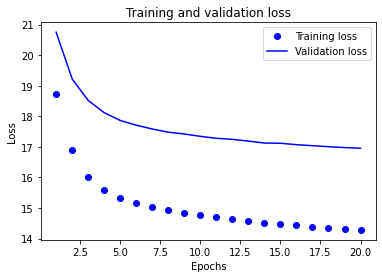

In [ ]:
entrainement_NN(NN=model_1, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='mse', 
                inputs=X_station_train[:,:,1], outputs=Y_train, 
                epochs=20, batch_size=300)

In [ ]:
Y_forecast_test = model_1.predict(X_station_train[:,:,1])


MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 97.2 %


In [ ]:
Y_forecast_model_1_mse = model_1.predict(X_station_test[:,:,1])

#### Expérience 1.1: loss=logcosh

Epoch 1/20
594/594 [==============================] - 2s 2ms/step - loss: 1.3868 - build_MAPE: 65.8552 - val_loss: 1.5644 - val_build_MAPE: 55.1940
Epoch 2/20
594/594 [==============================] - 1s 2ms/step - loss: 1.3253 - build_MAPE: 45.5343 - val_loss: 1.5527 - val_build_MAPE: 51.0041
Epoch 3/20
594/594 [==============================] - 1s 2ms/step - loss: 1.3218 - build_MAPE: 44.1035 - val_loss: 1.5498 - val_build_MAPE: 50.2364
Epoch 4/20
594/594 [==============================] - 1s 2ms/step - loss: 1.3197 - build_MAPE: 43.7757 - val_loss: 1.5458 - val_build_MAPE: 49.1826
Epoch 5/20
594/594 [==============================] - 1s 2ms/step - loss: 1.3182 - build_MAPE: 43.3212 - val_loss: 1.5464 - val_build_MAPE: 49.3716
Epoch 6/20
594/594 [==============================] - 1s 2ms/step - loss: 1.3169 - build_MAPE: 43.2615 - val_loss: 1.5425 - val_build_MAPE: 48.7464
Epoch 7/20
594/594 [==============================] - 1s 2ms/step - loss: 1.3158 - build_MAPE: 43.0817 - val_los

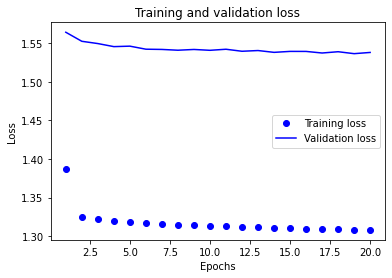

In [ ]:
entrainement_NN(NN=model_1, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='logcosh', 
                inputs=X_station_train[:,:,1], outputs=Y_train, 
                epochs=20, batch_size=200)

In [ ]:
Y_forecast_test = model_1.predict(X_station_train[:,:,1])


MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 44.0 %


In [ ]:
Y_forecast_model_1_1_logcosh = model_1.predict(X_station_test[:,:,1])

#### Expérience 1.2: loss=MAPE

Epoch 1/20
594/594 [==============================] - 2s 3ms/step - loss: 7134980.0000 - mae: 1.8395 - val_loss: 3785897.7500 - val_mae: 2.1658
Epoch 2/20
594/594 [==============================] - 1s 2ms/step - loss: 1286415.7500 - mae: 1.8514 - val_loss: 1083323.5000 - val_mae: 2.1735
Epoch 3/20
594/594 [==============================] - 1s 2ms/step - loss: 279512.7500 - mae: 1.8556 - val_loss: 359974.9688 - val_mae: 2.1766
Epoch 4/20
594/594 [==============================] - 1s 2ms/step - loss: 79446.7266 - mae: 1.8570 - val_loss: 163469.7969 - val_mae: 2.1775
Epoch 5/20
594/594 [==============================] - 2s 3ms/step - loss: 27155.7695 - mae: 1.8576 - val_loss: 70616.5312 - val_mae: 2.1781
Epoch 6/20
594/594 [==============================] - 1s 3ms/step - loss: 8470.9033 - mae: 1.8579 - val_loss: 46214.9570 - val_mae: 2.1783
Epoch 7/20
594/594 [==============================] - 2s 3ms/step - loss: 4294.6792 - mae: 1.8580 - val_loss: 36788.8125 - val_mae: 2.1785
Epoch 8/20


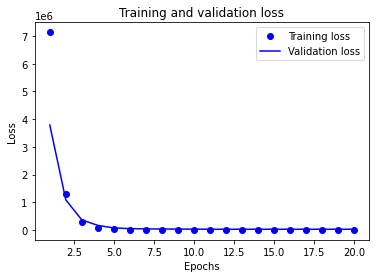

In [ ]:
entrainement_NN(NN=model_1, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='mape', 
                inputs=X_station_train[:,:,1], outputs=Y_train, 
                epochs=20, batch_size=200)

In [ ]:
Y_forecast_test = model_1.predict(X_station_train[:,:,1])


MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 31.7 %


In [ ]:
np.mean(Y_forecast_test)

0.008074455

In [ ]:
Y_forecast_model_1_2_mape = model_1.predict(X_station_test[:,:,1])

#### Expérience 1.3: loss=build_MAPE

Epoch 1/20
594/594 [==============================] - 2s 2ms/step - loss: 29.0124 - build_MAPE: 29.0124 - val_loss: 35.0667 - val_build_MAPE: 35.0667
Epoch 2/20
594/594 [==============================] - 1s 2ms/step - loss: 28.1872 - build_MAPE: 28.1872 - val_loss: 34.2788 - val_build_MAPE: 34.2788
Epoch 3/20
594/594 [==============================] - 1s 2ms/step - loss: 27.6564 - build_MAPE: 27.6564 - val_loss: 33.6924 - val_build_MAPE: 33.6924
Epoch 4/20
594/594 [==============================] - 1s 2ms/step - loss: 27.3515 - build_MAPE: 27.3515 - val_loss: 33.3689 - val_build_MAPE: 33.3689
Epoch 5/20
594/594 [==============================] - 1s 2ms/step - loss: 27.1684 - build_MAPE: 27.1684 - val_loss: 33.1338 - val_build_MAPE: 33.1338
Epoch 6/20
594/594 [==============================] - 1s 2ms/step - loss: 27.0516 - build_MAPE: 27.0516 - val_loss: 33.0202 - val_build_MAPE: 33.0202
Epoch 7/20
594/594 [==============================] - 1s 2ms/step - loss: 26.9758 - build_MAPE: 26.9

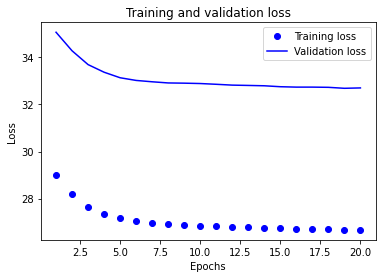

In [ ]:
entrainement_NN(NN=model_1, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_station_train[:,:,1], outputs=Y_train, 
                epochs=20, batch_size=200)

In [ ]:
Y_forecast_test = model_1.predict(X_station_train[:,:,1])

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 38.6 %


In [ ]:
np.mean(Y_forecast_test)

0.2244183

In [ ]:
Y_forecast_model_1_3_build_mape = model_1.predict(X_station_test[:,:,1])

In [ ]:
np.mean(Y_forecast_model_1_3_build_mape)

0.22527088

#### Expérience 2: X_station contenant les observations de précipitations et de température, loss=mse

In [ ]:
def sequential_1_1():
  inputs = Input(shape=(24,2), name='inputs')
  x = Flatten()(inputs)
  x = Dense(32, activation='relu', name='dense_1')(x)
  outputs = Dense(1, activation='relu', name='dense_2')(x)
  return Model(inputs, outputs, name='Sequential_1_1')

In [ ]:
model_2 = sequential_1_1()
model_2.summary()

Model: "Sequential_1_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 24, 2)]           0         
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1568      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
396/396 [==============================] - 1s 2ms/step - loss: 17.1384 - mae: 2.0565 - val_loss: 18.8188 - val_mae: 2.2207
Epoch 2/20
396/396 [==============================] - 1s 2ms/step - loss: 15.9014 - mae: 2.1178 - val_loss: 18.2791 - val_mae: 2.2060
Epoch 3/20
396/396 [==============================] - 1s 2ms/step - loss: 15.4270 - mae: 2.0965 - val_loss: 17.8439 - val_mae: 2.2117
Epoch 4/20
396/396 [==============================] - 1s 2ms/step - loss: 15.0876 - mae: 2.0763 - val_loss: 17.4930 - val_mae: 2.2191
Epoch 5/20
396/396 [==============================] - 1s 2ms/step - loss: 14.8168 - mae: 2.0696 - val_loss: 17.2691 - val_mae: 2.2151
Epoch 6/20
396/396 [==============================] - 1s 2ms/step - loss: 14.6000 - mae: 2.0528 - val_loss: 17.0556 - val_mae: 2.2507
Epoch 7/20
396/396 [==============================] - 1s 2ms/step - loss: 14.4229 - mae: 2.0557 - val_loss: 16.9112 - val_mae: 2.2630
Epoch 8/20
396/396 [==============================] - 1s 2ms/s

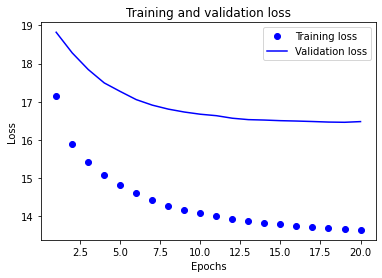

In [ ]:
entrainement_NN(NN=model_2, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='mse', 
                inputs=X_station_train, outputs=Y_train, 
                epochs=20, batch_size=300)

In [ ]:
Y_forecast_test = model_2.predict(X_station_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 101.2 %


In [ ]:
Y_forecast_model_2_mse = model_2.predict(X_station_test)

#### Expérience 2.1: loss=logcosh

Epoch 1/20
594/594 [==============================] - 2s 3ms/step - loss: 1.4772 - mae: 1.8380 - val_loss: 1.6354 - val_mae: 2.0271
Epoch 2/20
594/594 [==============================] - 1s 2ms/step - loss: 1.3883 - mae: 1.7505 - val_loss: 1.5803 - val_mae: 1.9856
Epoch 3/20
594/594 [==============================] - 1s 2ms/step - loss: 1.3519 - mae: 1.7162 - val_loss: 1.5552 - val_mae: 1.9679
Epoch 4/20
594/594 [==============================] - 1s 2ms/step - loss: 1.3354 - mae: 1.7013 - val_loss: 1.5429 - val_mae: 1.9574
Epoch 5/20
594/594 [==============================] - 1s 2ms/step - loss: 1.3263 - mae: 1.6928 - val_loss: 1.5359 - val_mae: 1.9473
Epoch 6/20
594/594 [==============================] - 1s 2ms/step - loss: 1.3205 - mae: 1.6864 - val_loss: 1.5299 - val_mae: 1.9517
Epoch 7/20
594/594 [==============================] - 1s 2ms/step - loss: 1.3162 - mae: 1.6825 - val_loss: 1.5272 - val_mae: 1.9467
Epoch 8/20
594/594 [==============================] - 1s 2ms/step - loss: 1.

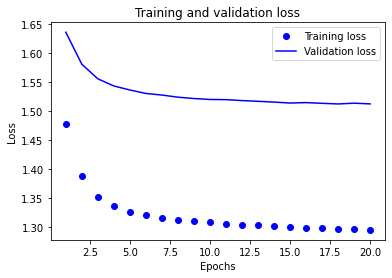

In [ ]:
entrainement_NN(NN=model_2, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='logcosh', 
                inputs=X_station_train, outputs=Y_train, 
                epochs=20, batch_size=200)

In [ ]:
Y_forecast_test = model_2.predict(X_station_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 51.1 %


In [ ]:
Y_forecast_model_2_1_logcosh = model_2.predict(X_station_test)

#### Expérience 2.2: loss=build_MAPE

Epoch 1/20
594/594 [==============================] - 2s 2ms/step - loss: 28.5094 - build_MAPE: 28.5094 - val_loss: 34.8009 - val_build_MAPE: 34.8009
Epoch 2/20
594/594 [==============================] - 1s 2ms/step - loss: 27.9140 - build_MAPE: 27.9140 - val_loss: 34.2270 - val_build_MAPE: 34.2270
Epoch 3/20
594/594 [==============================] - 1s 2ms/step - loss: 27.5277 - build_MAPE: 27.5277 - val_loss: 33.7108 - val_build_MAPE: 33.7108
Epoch 4/20
594/594 [==============================] - 1s 2ms/step - loss: 27.2505 - build_MAPE: 27.2505 - val_loss: 33.3532 - val_build_MAPE: 33.3532
Epoch 5/20
594/594 [==============================] - 1s 2ms/step - loss: 27.0429 - build_MAPE: 27.0429 - val_loss: 33.0236 - val_build_MAPE: 33.0236
Epoch 6/20
594/594 [==============================] - 1s 2ms/step - loss: 26.8792 - build_MAPE: 26.8792 - val_loss: 32.8933 - val_build_MAPE: 32.8933
Epoch 7/20
594/594 [==============================] - 1s 2ms/step - loss: 26.7900 - build_MAPE: 26.7

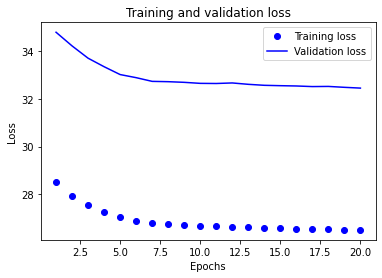

In [ ]:
entrainement_NN(NN=model_2, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_station_train, outputs=Y_train, 
                epochs=20, batch_size=200)

In [ ]:
Y_forecast_test = model_2.predict(X_station_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 38.4 %


In [ ]:
np.mean(Y_forecast_test)

0.25564238

In [ ]:
Y_forecast_model_2_2_build_mape = model_2.predict(X_station_test)

In [ ]:
np.mean(Y_forecast_model_2_2_build_mape)

0.24174443

### <u> b. sequential_2

#### Expérience 3: X_station contenant les observations de précipitations et de température, loss=mse

In [ ]:
def sequential_2():
  inputs = Input(shape=(24,2), name='inputs')
  x = Flatten()(inputs)
  x = Dense(256, activation='relu', name='dense_1')(x)
  x = Dense(32, activation='relu', name='dense_2')(x)
  outputs = Dense(1, activation='relu', name='dense_3')(x)
  return Model(inputs, outputs, name='Sequential_2')

In [ ]:
model_3 = sequential_2()
model_3.summary()

Model: "Sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 24, 2)]           0         
                                                                 
 flatten_1 (Flatten)         (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 256)               12544     
                                                                 
 dense_2 (Dense)             (None, 32)                8224      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
396/396 [==============================] - 2s 4ms/step - loss: 16.1712 - mae: 2.1200 - val_loss: 17.5083 - val_mae: 2.2287
Epoch 2/20
396/396 [==============================] - 1s 4ms/step - loss: 14.6464 - mae: 2.0707 - val_loss: 16.8287 - val_mae: 2.2929
Epoch 3/20
396/396 [==============================] - 1s 4ms/step - loss: 14.1208 - mae: 2.0517 - val_loss: 16.5314 - val_mae: 2.3057
Epoch 4/20
396/396 [==============================] - 1s 4ms/step - loss: 13.8163 - mae: 2.0422 - val_loss: 16.4944 - val_mae: 2.3565
Epoch 5/20
396/396 [==============================] - 1s 4ms/step - loss: 13.6285 - mae: 2.0374 - val_loss: 16.3946 - val_mae: 2.3514
Epoch 6/20
396/396 [==============================] - 1s 4ms/step - loss: 13.4948 - mae: 2.0298 - val_loss: 16.5397 - val_mae: 2.3742
Epoch 7/20
396/396 [==============================] - 2s 4ms/step - loss: 13.3960 - mae: 2.0211 - val_loss: 16.4293 - val_mae: 2.3999
Epoch 8/20
396/396 [==============================] - 1s 4ms/s

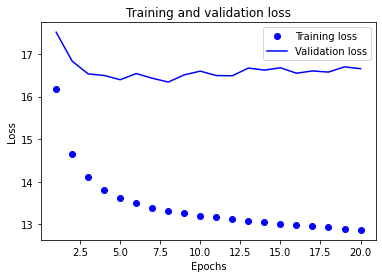

In [ ]:
entrainement_NN(NN=model_3, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='mse', 
                inputs=X_station_train, outputs=Y_train, 
                epochs=20, batch_size=300)

In [ ]:
Y_forecast_test = model_3.predict(X_station_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 132.7 %


In [ ]:
Y_forecast_model_3_mse = model_3.predict(X_station_test)


#### Expérience 3.1: Réduction du nombre d'epochs pour lutter contre le surajustement.

Epoch 1/8
396/396 [==============================] - 2s 5ms/step - loss: 16.2196 - mae: 2.1110 - val_loss: 17.5979 - val_mae: 2.2664
Epoch 2/8
396/396 [==============================] - 2s 4ms/step - loss: 14.6852 - mae: 2.0668 - val_loss: 16.8729 - val_mae: 2.2615
Epoch 3/8
396/396 [==============================] - 2s 4ms/step - loss: 14.1297 - mae: 2.0453 - val_loss: 16.5732 - val_mae: 2.3088
Epoch 4/8
396/396 [==============================] - 1s 4ms/step - loss: 13.8125 - mae: 2.0371 - val_loss: 16.4812 - val_mae: 2.4225
Epoch 5/8
396/396 [==============================] - 2s 4ms/step - loss: 13.6116 - mae: 2.0365 - val_loss: 16.4311 - val_mae: 2.3610
Epoch 6/8
396/396 [==============================] - 2s 4ms/step - loss: 13.4857 - mae: 2.0253 - val_loss: 16.4507 - val_mae: 2.4392
Epoch 7/8
396/396 [==============================] - 1s 4ms/step - loss: 13.3881 - mae: 2.0235 - val_loss: 16.4566 - val_mae: 2.3773
Epoch 8/8
396/396 [==============================] - 2s 4ms/step - lo

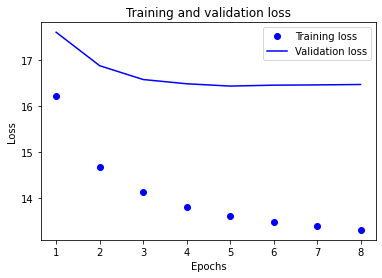

In [ ]:
entrainement_NN(NN=model_3, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='mse', 
                inputs=X_station_train, outputs=Y_train, 
                epochs=8, batch_size=300)

In [ ]:
Y_forecast_test = model_3.predict(X_station_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 115.2 %


In [ ]:
Y_forecast_model_3_mse = model_3.predict(X_station_test)

#### Expérience 3.2: loss=bluid_MAPE

Epoch 1/20
594/594 [==============================] - 3s 4ms/step - loss: 27.6266 - build_MAPE: 27.6266 - val_loss: 32.8548 - val_build_MAPE: 32.8548
Epoch 2/20
594/594 [==============================] - 2s 4ms/step - loss: 26.7214 - build_MAPE: 26.7214 - val_loss: 32.6675 - val_build_MAPE: 32.6675
Epoch 3/20
594/594 [==============================] - 2s 3ms/step - loss: 26.5529 - build_MAPE: 26.5529 - val_loss: 32.6134 - val_build_MAPE: 32.6134
Epoch 4/20
594/594 [==============================] - 2s 3ms/step - loss: 26.4630 - build_MAPE: 26.4630 - val_loss: 32.5448 - val_build_MAPE: 32.5448
Epoch 5/20
594/594 [==============================] - 2s 4ms/step - loss: 26.3876 - build_MAPE: 26.3876 - val_loss: 32.5640 - val_build_MAPE: 32.5640
Epoch 6/20
594/594 [==============================] - 2s 4ms/step - loss: 26.3282 - build_MAPE: 26.3282 - val_loss: 32.4655 - val_build_MAPE: 32.4655
Epoch 7/20
594/594 [==============================] - 2s 3ms/step - loss: 26.2851 - build_MAPE: 26.2

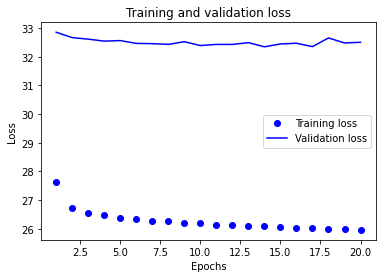

In [ ]:
entrainement_NN(NN=model_3, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_station_train, outputs=Y_train, 
                epochs=20, batch_size=200)

In [ ]:
Y_forecast_test = model_3.predict(X_station_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 37.8 %


In [ ]:
np.mean(Y_forecast_test)

0.29753146

In [ ]:
Y_forecast_model_3_2_build_mape = model_3.predict(X_station_test)

In [ ]:
np.mean(Y_forecast_model_3_2_build_mape)

0.3261098

### <u> c. sequential_3

#### Expérience 4: X_station contenant les observations de précipitations et de température, loss=mse

In [ ]:
def sequential_3():
  inputs = Input(shape=(24,2), name='inputs')
  x = Flatten()(inputs)
  x = Dense(64, activation='relu', name='dense_1')(x)
  x = Dense(128, activation='relu', name='dense_2')(x)
  x = Dropout(0.2)(x)
  x = Dense(128, activation='relu', name='dense_3')(x)
  x = Dropout(0.2)(x)
  x = Dense(64, activation='relu', name='dense_4')(x)
  x = Dense(32, activation='relu', name='dense_5')(x)
  outputs = Dense(1, activation='relu', name='dense_6')(x)
  return Model(inputs, outputs, name='Sequential_2')

In [ ]:
model_4 = sequential_3()
model_4.summary()

Model: "Sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 24, 2)]           0         
                                                                 
 flatten_2 (Flatten)         (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                3136      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)              

Epoch 1/20
1188/1188 [==============================] - 5s 4ms/step - loss: 15.4443 - mae: 2.1253 - val_loss: 16.9045 - val_mae: 2.3198
Epoch 2/20
1188/1188 [==============================] - 4s 4ms/step - loss: 14.2029 - mae: 2.0752 - val_loss: 16.4949 - val_mae: 2.3150
Epoch 3/20
1188/1188 [==============================] - 4s 4ms/step - loss: 13.8737 - mae: 2.0619 - val_loss: 16.4783 - val_mae: 2.3027
Epoch 4/20
1188/1188 [==============================] - 5s 4ms/step - loss: 13.7008 - mae: 2.0468 - val_loss: 16.5128 - val_mae: 2.3281
Epoch 5/20
1188/1188 [==============================] - 5s 4ms/step - loss: 13.5442 - mae: 2.0364 - val_loss: 16.6372 - val_mae: 2.3467
Epoch 6/20
1188/1188 [==============================] - 4s 4ms/step - loss: 13.4605 - mae: 2.0323 - val_loss: 16.5887 - val_mae: 2.3036
Epoch 7/20
1188/1188 [==============================] - 5s 4ms/step - loss: 13.3428 - mae: 2.0228 - val_loss: 16.6631 - val_mae: 2.2676
Epoch 8/20
1188/1188 [==========================

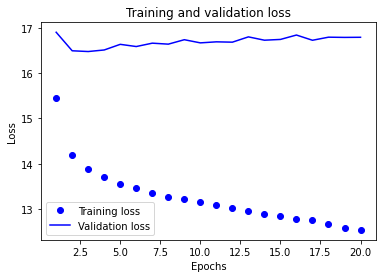

In [ ]:
entrainement_NN(NN=model_4, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='mse', 
                inputs=X_station_train, outputs=Y_train, 
                epochs=20, batch_size=100)

In [ ]:
Y_forecast_test = model_4.predict(X_station_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 117.4 %


#### Expérience 4.1: Réduction du nombre d'epochs pour lutter contre le surajustement.

Epoch 1/5
1188/1188 [==============================] - 5s 4ms/step - loss: 15.6467 - mae: 2.1299 - val_loss: 16.9363 - val_mae: 2.2037
Epoch 2/5
1188/1188 [==============================] - 4s 3ms/step - loss: 14.2263 - mae: 2.0804 - val_loss: 16.6120 - val_mae: 2.3566
Epoch 3/5
1188/1188 [==============================] - 4s 4ms/step - loss: 13.8830 - mae: 2.0600 - val_loss: 16.5513 - val_mae: 2.3817
Epoch 4/5
1188/1188 [==============================] - 4s 4ms/step - loss: 13.7141 - mae: 2.0500 - val_loss: 16.5693 - val_mae: 2.3736
Epoch 5/5
1188/1188 [==============================] - 4s 3ms/step - loss: 13.5712 - mae: 2.0469 - val_loss: 16.8009 - val_mae: 2.4310


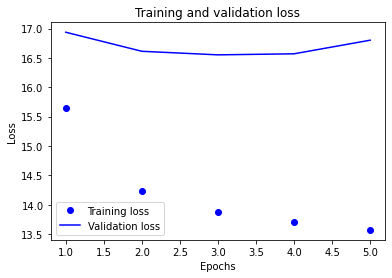

In [ ]:
entrainement_NN(NN=model_4, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='mse', 
                inputs=X_station_train, outputs=Y_train, 
                epochs=5, batch_size=100)

In [ ]:
Y_forecast_test = model_4.predict(X_station_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 114.1 %


In [ ]:
Y_forecast_model_4_mse = model_4.predict(X_station_test)

#### Expérience 4.2: loss=build_MAPE

Epoch 1/20
594/594 [==============================] - 4s 6ms/step - loss: 28.7930 - build_MAPE: 28.7930 - val_loss: 34.8309 - val_build_MAPE: 34.8309
Epoch 2/20
594/594 [==============================] - 3s 6ms/step - loss: 27.8813 - build_MAPE: 27.8813 - val_loss: 33.3785 - val_build_MAPE: 33.3785
Epoch 3/20
594/594 [==============================] - 3s 6ms/step - loss: 27.1992 - build_MAPE: 27.1992 - val_loss: 32.8243 - val_build_MAPE: 32.8243
Epoch 4/20
594/594 [==============================] - 3s 6ms/step - loss: 26.9523 - build_MAPE: 26.9523 - val_loss: 32.6553 - val_build_MAPE: 32.6553
Epoch 5/20
594/594 [==============================] - 3s 6ms/step - loss: 26.8774 - build_MAPE: 26.8774 - val_loss: 32.5110 - val_build_MAPE: 32.5110
Epoch 6/20
594/594 [==============================] - 3s 6ms/step - loss: 26.7785 - build_MAPE: 26.7785 - val_loss: 32.4235 - val_build_MAPE: 32.4235
Epoch 7/20
594/594 [==============================] - 3s 6ms/step - loss: 26.7195 - build_MAPE: 26.7

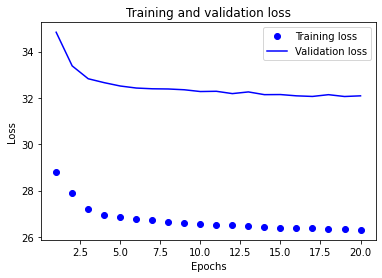

In [ ]:
entrainement_NN(NN=model_4, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_station_train, outputs=Y_train, 
                epochs=20, batch_size=200)

In [ ]:
Y_forecast_test = model_4.predict(X_station_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 37.6 %


In [ ]:
np.mean(Y_forecast_test)

0.25452372

In [ ]:
Y_forecast_model_4_2_build_mape = model_4.predict(X_station_test)

In [ ]:
np.mean(Y_forecast_model_4_2_build_mape)

0.25964636

### d. Sequential_3_2

#### Expérience 5: X_station et X_forecast, loss=build_MAPE

In [ ]:
def sequential_3_2():
  inputs = Input(shape=(24,2), name='inputs')
  inputs_2 = Input(shape=(24,7), name='inputs_2')
  x = Concatenate(axis=2)([inputs, inputs_2])
  x = Flatten()(x)
  x = Dense(64, activation='relu', name='dense_1')(x)
  x = Dense(128, activation='relu', name='dense_2')(x)
  x = Dropout(0.2)(x)
  x = Dense(128, activation='relu', name='dense_3')(x)
  x = Dropout(0.2)(x)
  x = Dense(64, activation='relu', name='dense_4')(x)
  x = Dense(32, activation='relu', name='dense_5')(x)
  outputs = Dense(1, activation='relu', name='dense_6')(x)
  return Model([inputs, inputs_2], outputs, name='Sequential_3_2')

In [ ]:
model_5 = sequential_3_2()
model_5.summary()

Model: "Sequential_3_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 24, 2)]      0           []                               
                                                                                                  
 inputs_2 (InputLayer)          [(None, 24, 7)]      0           []                               
                                                                                                  
 concatenate_12 (Concatenate)   (None, 24, 9)        0           ['inputs[0][0]',                 
                                                                  'inputs_2[0][0]']               
                                                                                                  
 flatten_11 (Flatten)           (None, 216)          0           ['concatenate_12[0][

Epoch 1/10
594/594 [==============================] - 6s 7ms/step - loss: 24.9392 - build_MAPE: 24.9392 - val_loss: 29.2108 - val_build_MAPE: 29.2108
Epoch 2/10
594/594 [==============================] - 4s 6ms/step - loss: 23.2532 - build_MAPE: 23.2532 - val_loss: 28.6083 - val_build_MAPE: 28.6083
Epoch 3/10
594/594 [==============================] - 4s 6ms/step - loss: 22.6369 - build_MAPE: 22.6369 - val_loss: 28.0177 - val_build_MAPE: 28.0177
Epoch 4/10
594/594 [==============================] - 4s 6ms/step - loss: 22.2514 - build_MAPE: 22.2514 - val_loss: 27.8417 - val_build_MAPE: 27.8417
Epoch 5/10
594/594 [==============================] - 4s 6ms/step - loss: 21.8779 - build_MAPE: 21.8779 - val_loss: 27.6139 - val_build_MAPE: 27.6139
Epoch 6/10
594/594 [==============================] - 4s 6ms/step - loss: 21.6615 - build_MAPE: 21.6615 - val_loss: 27.4775 - val_build_MAPE: 27.4775
Epoch 7/10
594/594 [==============================] - 4s 6ms/step - loss: 21.4189 - build_MAPE: 21.4

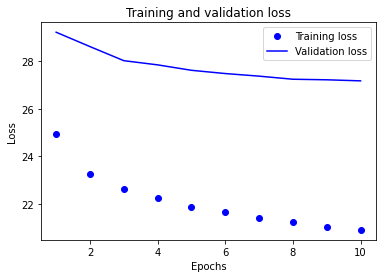

In [ ]:
entrainement_NN(NN=model_5, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=[X_station_train, X_forecast_train[:,:,:-4]], outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_test = model_5.predict([X_station_test, X_forecast_test[:,:,:-4]])   # epochs=20, batch_size=200

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

ValueError: ignored

In [ ]:
np.mean(Y_forecast_test)

0.9549089

In [ ]:
Y_forecast_test = model_5.predict([X_station_train, X_forecast_train[:,:,:-4]])   # epochs=10, batch_size=200

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 52.8 %


In [ ]:
np.mean(Y_forecast_test)

0.8836996

In [ ]:
Y_forecast_model_5_build_mape = model_5.predict([X_station_test, X_forecast_test[:,:,:-4]])

In [ ]:
np.mean(Y_forecast_model_5_build_mape)

0.77733326

#### Expérience 5.1: loss=logcosh

Epoch 1/10
594/594 [==============================] - 4s 6ms/step - loss: 0.9456 - build_MAPE: 34.1716 - val_loss: 0.9911 - val_build_MAPE: 36.7711
Epoch 2/10
594/594 [==============================] - 3s 5ms/step - loss: 0.8165 - build_MAPE: 31.1754 - val_loss: 0.9562 - val_build_MAPE: 33.8940
Epoch 3/10
594/594 [==============================] - 3s 5ms/step - loss: 0.7872 - build_MAPE: 30.3491 - val_loss: 0.9415 - val_build_MAPE: 32.9024
Epoch 4/10
594/594 [==============================] - 3s 5ms/step - loss: 0.7652 - build_MAPE: 29.8079 - val_loss: 0.9316 - val_build_MAPE: 34.1648
Epoch 5/10
594/594 [==============================] - 3s 5ms/step - loss: 0.7476 - build_MAPE: 29.2616 - val_loss: 0.9356 - val_build_MAPE: 33.8452
Epoch 6/10
594/594 [==============================] - 3s 5ms/step - loss: 0.7343 - build_MAPE: 28.8447 - val_loss: 0.9339 - val_build_MAPE: 33.0087
Epoch 7/10
594/594 [==============================] - 3s 5ms/step - loss: 0.7240 - build_MAPE: 28.4617 - val_los

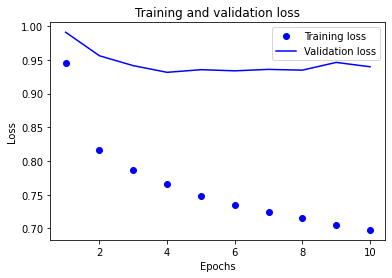

In [ ]:
entrainement_NN(NN=model_5, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='logcosh', 
                inputs=[X_station_train, X_forecast_train[:,:,:-4]], outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_model_5_1_logcosh = model_5.predict([X_station_test, X_forecast_test[:,:,:-4]])

In [ ]:
np.mean(Y_forecast_model_5_1_logcosh)

1.5500201

#### Expérience 5.2: loss=mse

Epoch 1/10
594/594 [==============================] - 4s 5ms/step - loss: 10.8575 - build_MAPE: 46.2555 - val_loss: 8.0725 - val_build_MAPE: 43.2057
Epoch 2/10
594/594 [==============================] - 3s 5ms/step - loss: 6.8487 - build_MAPE: 40.8467 - val_loss: 7.6019 - val_build_MAPE: 43.6651
Epoch 3/10
594/594 [==============================] - 3s 5ms/step - loss: 6.5070 - build_MAPE: 39.5894 - val_loss: 7.5805 - val_build_MAPE: 45.0181
Epoch 4/10
594/594 [==============================] - 3s 5ms/step - loss: 6.3071 - build_MAPE: 39.1550 - val_loss: 7.5712 - val_build_MAPE: 41.7406
Epoch 5/10
594/594 [==============================] - 3s 5ms/step - loss: 6.0902 - build_MAPE: 38.2615 - val_loss: 7.6058 - val_build_MAPE: 41.1291
Epoch 6/10
594/594 [==============================] - 3s 5ms/step - loss: 5.9627 - build_MAPE: 37.8464 - val_loss: 7.4295 - val_build_MAPE: 41.1729
Epoch 7/10
594/594 [==============================] - 3s 5ms/step - loss: 5.7904 - build_MAPE: 37.1214 - val_lo

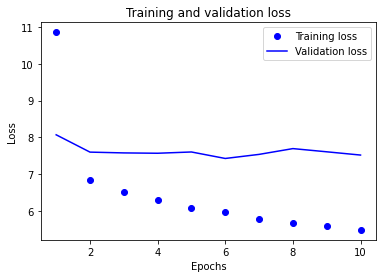

In [ ]:
entrainement_NN(NN=model_5, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='mse', 
                inputs=[X_station_train, X_forecast_train[:,:,:-4]], outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_model_5_2_mse = model_5.predict([X_station_test, X_forecast_test[:,:,:-4]])

In [ ]:
np.mean(Y_forecast_model_5_2_mse)

1.717206

#### Expérience 5.3: loss=mae

Epoch 1/10
594/594 [==============================] - 4s 5ms/step - loss: 1.2444 - build_MAPE: 28.8043 - val_loss: 1.3087 - val_build_MAPE: 33.0401
Epoch 2/10
594/594 [==============================] - 3s 5ms/step - loss: 1.0905 - build_MAPE: 27.5432 - val_loss: 1.2736 - val_build_MAPE: 32.0438
Epoch 3/10
594/594 [==============================] - 3s 5ms/step - loss: 1.0587 - build_MAPE: 26.9438 - val_loss: 1.2556 - val_build_MAPE: 31.1025
Epoch 4/10
594/594 [==============================] - 3s 5ms/step - loss: 1.0404 - build_MAPE: 26.3699 - val_loss: 1.2502 - val_build_MAPE: 31.2826
Epoch 5/10
594/594 [==============================] - 3s 5ms/step - loss: 1.0285 - build_MAPE: 26.0897 - val_loss: 1.2501 - val_build_MAPE: 32.2490
Epoch 6/10
594/594 [==============================] - 3s 5ms/step - loss: 1.0134 - build_MAPE: 25.7446 - val_loss: 1.2426 - val_build_MAPE: 30.3104
Epoch 7/10
594/594 [==============================] - 3s 5ms/step - loss: 1.0018 - build_MAPE: 25.3794 - val_los

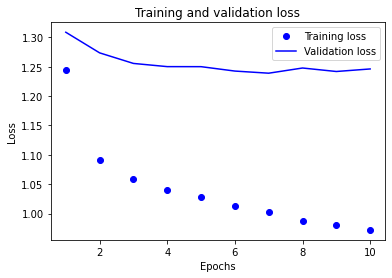

In [ ]:
entrainement_NN(NN=model_5, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='mae', 
                inputs=[X_station_train, X_forecast_train[:,:,:-4]], outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_model_5_3_mae = model_5.predict([X_station_test, X_forecast_test[:,:,:-4]])

In [ ]:
np.mean(Y_forecast_model_5_3_mae)

1.4526389

### e. Sequential_3_3

#### Expérience 6: X_forecast avec prédicteurs constants, loss=build_MAPE

In [ ]:
def sequential_3_3():
  inputs = Input(shape=(24,11), name='inputs')
  x = Flatten()(inputs)
  x = Dense(64, activation='relu', name='dense_1')(x)
  x = Dense(128, activation='relu', name='dense_2')(x)
  x = Dropout(0.2)(x)
  x = Dense(128, activation='relu', name='dense_3')(x)
  x = Dropout(0.2)(x)
  x = Dense(64, activation='relu', name='dense_4')(x)
  x = Dense(32, activation='relu', name='dense_5')(x)
  outputs = Dense(1, activation='relu', name='dense_6')(x)
  return Model(inputs, outputs, name='Sequential_3_3')

In [ ]:
model_6 = sequential_3_3()
model_6.summary()

Model: "Sequential_3_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 24, 11)]          0         
                                                                 
 flatten_3 (Flatten)         (None, 264)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16960     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)            

Epoch 1/10
594/594 [==============================] - 5s 7ms/step - loss: 25.1575 - build_MAPE: 25.1575 - val_loss: 29.3519 - val_build_MAPE: 29.3519
Epoch 2/10
594/594 [==============================] - 4s 6ms/step - loss: 23.3084 - build_MAPE: 23.3084 - val_loss: 29.1552 - val_build_MAPE: 29.1552
Epoch 3/10
594/594 [==============================] - 4s 6ms/step - loss: 22.9071 - build_MAPE: 22.9071 - val_loss: 28.9398 - val_build_MAPE: 28.9398
Epoch 4/10
594/594 [==============================] - 4s 6ms/step - loss: 22.6162 - build_MAPE: 22.6162 - val_loss: 29.4759 - val_build_MAPE: 29.4759
Epoch 5/10
594/594 [==============================] - 4s 6ms/step - loss: 22.3484 - build_MAPE: 22.3484 - val_loss: 29.1336 - val_build_MAPE: 29.1336
Epoch 6/10
594/594 [==============================] - 4s 7ms/step - loss: 22.0750 - build_MAPE: 22.0750 - val_loss: 29.1090 - val_build_MAPE: 29.1090
Epoch 7/10
594/594 [==============================] - 4s 7ms/step - loss: 21.8611 - build_MAPE: 21.8

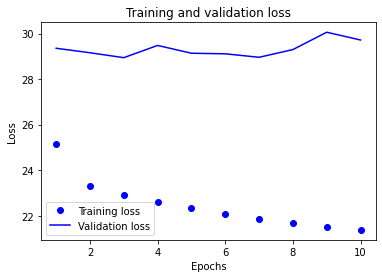

In [ ]:
entrainement_NN(NN=model_6, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_forecast_train, outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_test = model_6.predict(X_forecast_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 49.8 %


In [ ]:
np.mean(Y_forecast_test)

0.896569

In [ ]:
Y_forecast_model_6_build_mape = model_6.predict(X_forecast_test)

In [ ]:
np.mean(Y_forecast_model_6_build_mape)

0.9364362

### f. Sequential_3_4

#### Expérience 17: X_station et X_forecast avec prédicteurs constants, loss=build_MAPE

In [ ]:
def sequential_3_4():
  inputs = Input(shape=(24,2), name='inputs')
  inputs_2 = Input(shape=(24,11), name='inputs_2')
  x = Concatenate(axis=2)([inputs, inputs_2])
  x = Flatten()(x)
  x = Dense(64, activation='relu', name='dense_1')(x)
  x = Dense(128, activation='relu', name='dense_2')(x)
  x = Dropout(0.2)(x)
  x = Dense(128, activation='relu', name='dense_3')(x)
  x = Dropout(0.2)(x)
  x = Dense(64, activation='relu', name='dense_4')(x)
  x = Dense(32, activation='relu', name='dense_5')(x)
  outputs = Dense(1, activation='relu', name='dense_6')(x)
  return Model([inputs, inputs_2], outputs, name='Sequential_3_4')

In [ ]:
model_17 = sequential_3_4()
model_17.summary()

Model: "Sequential_3_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 24, 2)]      0           []                               
                                                                                                  
 inputs_2 (InputLayer)          [(None, 24, 11)]     0           []                               
                                                                                                  
 concatenate_9 (Concatenate)    (None, 24, 13)       0           ['inputs[0][0]',                 
                                                                  'inputs_2[0][0]']               
                                                                                                  
 flatten_6 (Flatten)            (None, 312)          0           ['concatenate_9[0][0

Epoch 1/10
594/594 [==============================] - 5s 7ms/step - loss: 25.2226 - build_MAPE: 25.2226 - val_loss: 29.2997 - val_build_MAPE: 29.2997
Epoch 2/10
594/594 [==============================] - 4s 7ms/step - loss: 23.1216 - build_MAPE: 23.1216 - val_loss: 28.9551 - val_build_MAPE: 28.9551
Epoch 3/10
594/594 [==============================] - 4s 7ms/step - loss: 22.5226 - build_MAPE: 22.5226 - val_loss: 28.4263 - val_build_MAPE: 28.4263
Epoch 4/10
594/594 [==============================] - 4s 7ms/step - loss: 22.0810 - build_MAPE: 22.0810 - val_loss: 28.4436 - val_build_MAPE: 28.4436
Epoch 5/10
594/594 [==============================] - 4s 7ms/step - loss: 21.7506 - build_MAPE: 21.7506 - val_loss: 28.0688 - val_build_MAPE: 28.0688
Epoch 6/10
594/594 [==============================] - 4s 7ms/step - loss: 21.4681 - build_MAPE: 21.4681 - val_loss: 27.8452 - val_build_MAPE: 27.8452
Epoch 7/10
594/594 [==============================] - 4s 7ms/step - loss: 21.2130 - build_MAPE: 21.2

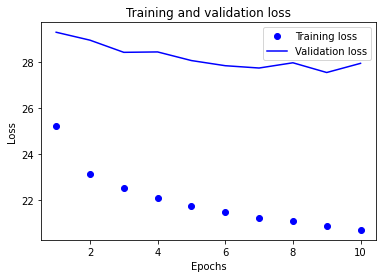

In [ ]:
entrainement_NN(NN=model_17, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=[X_station_train, X_forecast_train], outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_model_17_build_mape = model_17.predict([X_station_test, X_forecast_test])

In [ ]:
np.mean(Y_forecast_model_17_build_mape)

0.8533482

### g. Sequential_3_5

#### Expérience 18: X_forecast, loss=build_MAPE

In [ ]:
def sequential_3_5():
  inputs = Input(shape=(24,7), name='inputs')
  x = Flatten()(inputs)
  x = Dense(64, activation='relu', name='dense_1')(x)
  x = Dense(128, activation='relu', name='dense_2')(x)
  x = Dropout(0.2)(x)
  x = Dense(128, activation='relu', name='dense_3')(x)
  x = Dropout(0.2)(x)
  x = Dense(64, activation='relu', name='dense_4')(x)
  x = Dense(32, activation='relu', name='dense_5')(x)
  outputs = Dense(1, activation='relu', name='dense_6')(x)
  return Model(inputs, outputs, name='Sequential_3_5')

In [ ]:
model_18 = sequential_3_5()
model_18.summary()

Model: "Sequential_3_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 24, 7)]           0         
                                                                 
 flatten_7 (Flatten)         (None, 168)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                10816     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)            

Epoch 1/10
594/594 [==============================] - 4s 6ms/step - loss: 25.0559 - build_MAPE: 25.0559 - val_loss: 29.3661 - val_build_MAPE: 29.3661
Epoch 2/10
594/594 [==============================] - 4s 6ms/step - loss: 23.3828 - build_MAPE: 23.3828 - val_loss: 28.8659 - val_build_MAPE: 28.8659
Epoch 3/10
594/594 [==============================] - 4s 6ms/step - loss: 22.9347 - build_MAPE: 22.9347 - val_loss: 28.5835 - val_build_MAPE: 28.5835
Epoch 4/10
594/594 [==============================] - 4s 6ms/step - loss: 22.6448 - build_MAPE: 22.6448 - val_loss: 28.4595 - val_build_MAPE: 28.4595
Epoch 5/10
594/594 [==============================] - 4s 6ms/step - loss: 22.4080 - build_MAPE: 22.4080 - val_loss: 28.3350 - val_build_MAPE: 28.3350
Epoch 6/10
594/594 [==============================] - 4s 6ms/step - loss: 22.2157 - build_MAPE: 22.2157 - val_loss: 28.3365 - val_build_MAPE: 28.3365
Epoch 7/10
594/594 [==============================] - 3s 6ms/step - loss: 22.0171 - build_MAPE: 22.0

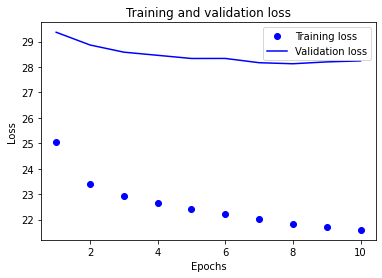

In [ ]:
entrainement_NN(NN=model_18, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_forecast_train[:,:,:-4], outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_model_18_build_mape = model_18.predict(X_forecast_test[:,:,:-4])

In [ ]:
np.mean(Y_forecast_model_18_build_mape)

0.87725574

## 3.2. Entraînement et évaluation d'un modèle LSTM.

### <u> a. lstm_1

#### Expérience 7: LSTM_1 avec X_station, loss=mse

In [ ]:
def lstm_1():  
  inputs = Input(shape=(24, 2), name='encoder_inputs')

  x = LSTM(32, name='lstm')(inputs)
  x = Dense(8, activation='relu')(x)
  outputs = Dense(1, activation='relu')(x)

  return Model(inputs, outputs, name='lstm_1')

In [ ]:
model_7 = lstm_1()
model_7.summary()

Model: "lstm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 24, 2)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                4480      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,753
Trainable params: 4,753
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
1188/1188 [==============================] - 20s 15ms/step - loss: 16.2780 - mae: 2.1697 - val_loss: 17.9512 - val_mae: 2.4697
Epoch 2/10
1188/1188 [==============================] - 17s 14ms/step - loss: 14.8922 - mae: 2.2092 - val_loss: 17.7534 - val_mae: 2.4162
Epoch 3/10
1188/1188 [==============================] - 17s 14ms/step - loss: 14.6903 - mae: 2.1832 - val_loss: 17.6783 - val_mae: 2.3757
Epoch 4/10
1188/1188 [==============================] - 17s 14ms/step - loss: 14.5710 - mae: 2.1622 - val_loss: 17.5457 - val_mae: 2.4618
Epoch 5/10
1188/1188 [==============================] - 17s 14ms/step - loss: 14.4801 - mae: 2.1503 - val_loss: 17.4759 - val_mae: 2.4441
Epoch 6/10
1188/1188 [==============================] - 17s 14ms/step - loss: 14.3691 - mae: 2.1375 - val_loss: 17.4762 - val_mae: 2.4236
Epoch 7/10
1188/1188 [==============================] - 17s 14ms/step - loss: 14.2712 - mae: 2.1223 - val_loss: 17.5268 - val_mae: 2.4450
Epoch 8/10
1188/1188 [============

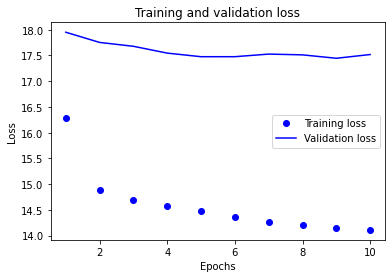

In [ ]:
entrainement_NN(NN=model_7, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='mse', 
                inputs=X_station_train, outputs=Y_train, 
                epochs=10, batch_size=100)

In [ ]:
Y_forecast_test = model_7.predict(X_station_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 69.4 %


In [ ]:
Y_forecast_model_7_mse = model_7.predict(X_station_test)

#### Expérience 7.1: loss=logcosh

Epoch 1/10
297/297 [==============================] - 14s 37ms/step - loss: 1.4877 - mae: 1.8370 - val_loss: 1.6488 - val_mae: 2.0659
Epoch 2/10
297/297 [==============================] - 11s 36ms/step - loss: 1.4047 - mae: 1.7884 - val_loss: 1.6279 - val_mae: 2.0485
Epoch 3/10
297/297 [==============================] - 11s 35ms/step - loss: 1.3889 - mae: 1.7682 - val_loss: 1.6108 - val_mae: 2.0338
Epoch 4/10
297/297 [==============================] - 11s 35ms/step - loss: 1.3753 - mae: 1.7523 - val_loss: 1.5979 - val_mae: 2.0237
Epoch 5/10
297/297 [==============================] - 11s 35ms/step - loss: 1.3653 - mae: 1.7409 - val_loss: 1.5918 - val_mae: 2.0092
Epoch 6/10
297/297 [==============================] - 11s 36ms/step - loss: 1.3577 - mae: 1.7312 - val_loss: 1.5852 - val_mae: 2.0117
Epoch 7/10
297/297 [==============================] - 11s 36ms/step - loss: 1.3527 - mae: 1.7249 - val_loss: 1.5814 - val_mae: 2.0097
Epoch 8/10
297/297 [==============================] - 11s 36ms

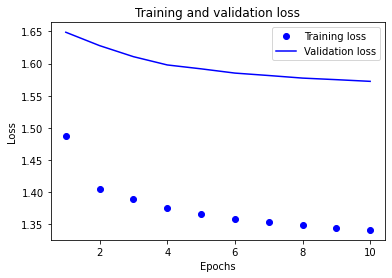

In [ ]:
entrainement_NN(NN=model_7, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='logcosh', 
                inputs=X_station_train, outputs=Y_train, 
                epochs=10, batch_size=400)

In [ ]:
Y_forecast_test = model_7.predict(X_station_train)  # batchsize=100

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 31.5 %


In [ ]:
Y_forecast_test = model_7.predict(X_station_train)  # batchsize=400

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 31.8 %


In [ ]:
Y_forecast_test.shape

(72505, 1)

In [ ]:
Y_test.shape

(72505, 1)

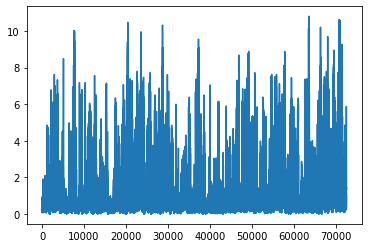

In [ ]:
plt.plot(Y_forecast_test)

In [ ]:
Y_forecast_model_7_1_logcosh = model_7.predict(X_station_test)

#### Expérience 7.2: loss=build_MAPE

Epoch 1/10
594/594 [==============================] - 16s 22ms/step - loss: 28.3029 - build_MAPE: 28.3029 - val_loss: 34.5222 - val_build_MAPE: 34.5222
Epoch 2/10
594/594 [==============================] - 13s 21ms/step - loss: 28.0500 - build_MAPE: 28.0500 - val_loss: 34.3766 - val_build_MAPE: 34.3766
Epoch 3/10
594/594 [==============================] - 13s 21ms/step - loss: 27.9422 - build_MAPE: 27.9422 - val_loss: 34.3018 - val_build_MAPE: 34.3018
Epoch 4/10
594/594 [==============================] - 13s 21ms/step - loss: 27.8921 - build_MAPE: 27.8921 - val_loss: 34.2347 - val_build_MAPE: 34.2347
Epoch 5/10
594/594 [==============================] - 12s 21ms/step - loss: 27.8581 - build_MAPE: 27.8581 - val_loss: 34.1816 - val_build_MAPE: 34.1816
Epoch 6/10
594/594 [==============================] - 13s 21ms/step - loss: 27.8296 - build_MAPE: 27.8296 - val_loss: 34.1375 - val_build_MAPE: 34.1375
Epoch 7/10
594/594 [==============================] - 12s 21ms/step - loss: 27.8051 - bu

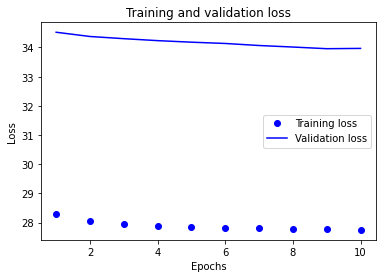

In [ ]:
entrainement_NN(NN=model_7, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_station_train, outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_test = model_7.predict(X_station_train)  # batchsize=400

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 28.5 %


In [ ]:
np.mean(Y_forecast_test)

0.13874005

In [ ]:
Y_forecast_model_7_2_build_mape = model_7.predict(X_station_test)

In [ ]:
np.mean(Y_forecast_model_7_2_build_mape)

0.15156372

#### Expérience 8: LSTM_1(dropout) avec X_station, loss=mse

In [ ]:
def lstm_1_1():  
  inputs = Input(shape=(24, 2), name='encoder_inputs')

  x = LSTM(32, dropout=0.2, recurrent_dropout=0.2, name='lstm')(inputs)
  x = Dense(8, activation='relu')(x)
  outputs = Dense(1, activation='relu')(x)

  return Model(inputs, outputs, name='lstm_1_1')

In [ ]:
model_8 = lstm_1_1()
model_8.summary()

Model: "lstm_1_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 24, 2)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                4480      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,753
Trainable params: 4,753
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
1188/1188 [==============================] - 33s 26ms/step - loss: 16.9076 - mae: 2.1639 - val_loss: 17.9873 - val_mae: 2.4576
Epoch 2/10
1188/1188 [==============================] - 31s 26ms/step - loss: 14.9842 - mae: 2.2079 - val_loss: 17.8384 - val_mae: 2.4511
Epoch 3/10
1188/1188 [==============================] - 30s 26ms/step - loss: 14.8206 - mae: 2.1873 - val_loss: 17.6259 - val_mae: 2.4715
Epoch 4/10
1188/1188 [==============================] - 31s 26ms/step - loss: 14.6921 - mae: 2.1726 - val_loss: 17.5908 - val_mae: 2.3882
Epoch 5/10
1188/1188 [==============================] - 30s 26ms/step - loss: 14.6027 - mae: 2.1585 - val_loss: 17.7130 - val_mae: 2.4283
Epoch 6/10
1188/1188 [==============================] - 31s 26ms/step - loss: 14.5453 - mae: 2.1461 - val_loss: 17.5980 - val_mae: 2.4972
Epoch 7/10
1188/1188 [==============================] - 31s 26ms/step - loss: 14.4693 - mae: 2.1372 - val_loss: 17.5283 - val_mae: 2.4964
Epoch 8/10
1188/1188 [============

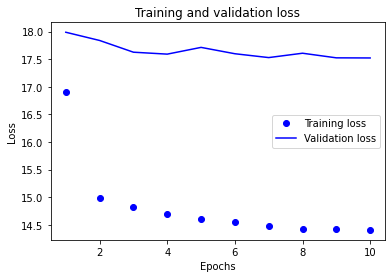

In [ ]:
entrainement_NN(NN=model_8, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='mse', 
                inputs=X_station_train, outputs=Y_train, 
                epochs=10, batch_size=100)

In [ ]:
Y_forecast_test = model_8.predict(X_station_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 69.8 %


In [ ]:
Y_forecast_model_8_mse = model_8.predict(X_station_test)

#### Expérience 8.1: loss=build_MAPE

Epoch 1/10
594/594 [==============================] - 23s 34ms/step - loss: 28.5899 - build_MAPE: 28.5899 - val_loss: 34.7462 - val_build_MAPE: 34.7462
Epoch 2/10
594/594 [==============================] - 20s 33ms/step - loss: 28.3124 - build_MAPE: 28.3124 - val_loss: 34.5979 - val_build_MAPE: 34.5979
Epoch 3/10
594/594 [==============================] - 20s 34ms/step - loss: 28.2030 - build_MAPE: 28.2030 - val_loss: 34.4398 - val_build_MAPE: 34.4398
Epoch 4/10
594/594 [==============================] - 20s 34ms/step - loss: 28.1131 - build_MAPE: 28.1131 - val_loss: 34.3950 - val_build_MAPE: 34.3950
Epoch 5/10
594/594 [==============================] - 20s 33ms/step - loss: 28.0537 - build_MAPE: 28.0537 - val_loss: 34.3325 - val_build_MAPE: 34.3325
Epoch 6/10
594/594 [==============================] - 20s 33ms/step - loss: 28.0008 - build_MAPE: 28.0008 - val_loss: 34.3166 - val_build_MAPE: 34.3166
Epoch 7/10
594/594 [==============================] - 20s 33ms/step - loss: 27.9945 - bu

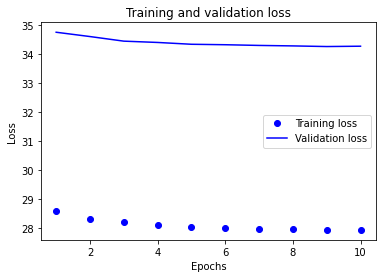

In [ ]:
entrainement_NN(NN=model_8, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_station_train, outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_test = model_8.predict(X_station_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 28.6 %


In [ ]:
np.mean(Y_forecast_test)

0.15233608

In [ ]:
Y_forecast_model_8_1_build_mape = model_8.predict(X_station_test)

In [ ]:
np.mean(Y_forecast_model_8_1_build_mape)

0.13380367

#### Expérience 9: LSTM_1(dropout)*4_coefficients avec X_station, loss=mse

In [ ]:
def lstm_1_2():  
  inputs = Input(shape=(24, 2), name='encoder_inputs')

  x = LSTM(64, dropout=0.2, recurrent_dropout=0.2, name='lstm')(inputs)
  x = Dense(8, activation='relu')(x)
  outputs = Dense(1, activation='relu')(x)

  return Model(inputs, outputs, name='lstm_1_2')

In [ ]:
model_9 = lstm_1_2()
model_9.summary()

Model: "lstm_1_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 24, 2)]          0         
                                                                 
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,681
Trainable params: 17,681
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
1188/1188 [==============================] - 47s 38ms/step - loss: 16.2097 - mae: 2.1958 - val_loss: 18.0574 - val_mae: 2.3590
Epoch 2/10
1188/1188 [==============================] - 44s 37ms/step - loss: 14.9518 - mae: 2.2056 - val_loss: 17.7027 - val_mae: 2.3782
Epoch 3/10
1188/1188 [==============================] - 45s 37ms/step - loss: 14.7438 - mae: 2.1800 - val_loss: 17.6279 - val_mae: 2.3816
Epoch 4/10
1188/1188 [==============================] - 44s 37ms/step - loss: 14.5894 - mae: 2.1635 - val_loss: 17.5891 - val_mae: 2.4651
Epoch 5/10
1188/1188 [==============================] - 45s 38ms/step - loss: 14.4961 - mae: 2.1477 - val_loss: 17.5201 - val_mae: 2.4385
Epoch 6/10
1188/1188 [==============================] - 44s 37ms/step - loss: 14.4215 - mae: 2.1405 - val_loss: 17.5548 - val_mae: 2.4573
Epoch 7/10
1188/1188 [==============================] - 44s 37ms/step - loss: 14.3552 - mae: 2.1318 - val_loss: 17.4836 - val_mae: 2.3907
Epoch 8/10
1188/1188 [============

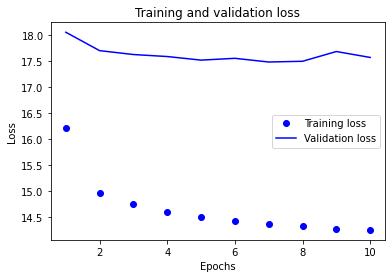

In [ ]:
entrainement_NN(NN=model_9, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='mse', 
                inputs=X_station_train, outputs=Y_train, 
                epochs=10, batch_size=100)

In [ ]:
Y_forecast_test = model_9.predict(X_station_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 70.6 %


In [ ]:
Y_forecast_model_9_mse = model_9.predict(X_station_test)

#### Expérience 9.1: loss=build_MAPE

Epoch 1/10
594/594 [==============================] - 37s 58ms/step - loss: 28.6914 - build_MAPE: 28.6914 - val_loss: 34.7384 - val_build_MAPE: 34.7384
Epoch 2/10
594/594 [==============================] - 34s 57ms/step - loss: 28.2614 - build_MAPE: 28.2614 - val_loss: 34.3318 - val_build_MAPE: 34.3318
Epoch 3/10
594/594 [==============================] - 34s 57ms/step - loss: 28.1142 - build_MAPE: 28.1142 - val_loss: 34.2539 - val_build_MAPE: 34.2539
Epoch 4/10
594/594 [==============================] - 34s 57ms/step - loss: 28.0433 - build_MAPE: 28.0433 - val_loss: 34.2091 - val_build_MAPE: 34.2091
Epoch 5/10
594/594 [==============================] - 34s 57ms/step - loss: 27.9643 - build_MAPE: 27.9643 - val_loss: 34.1696 - val_build_MAPE: 34.1696
Epoch 6/10
594/594 [==============================] - 34s 57ms/step - loss: 27.9161 - build_MAPE: 27.9161 - val_loss: 34.0879 - val_build_MAPE: 34.0879
Epoch 7/10
594/594 [==============================] - 34s 58ms/step - loss: 27.8802 - bu

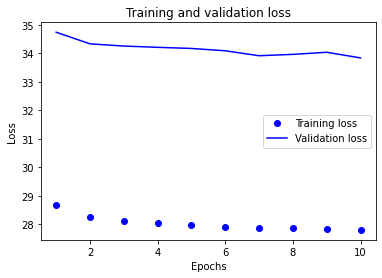

In [ ]:
entrainement_NN(NN=model_9, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_station_train, outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_test = model_9.predict(X_station_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 29.0 %


In [ ]:
np.mean(Y_forecast_test)

0.14052533

In [ ]:
Y_forecast_model_9_1_build_mape = model_9.predict(X_station_test)

In [ ]:
np.mean(Y_forecast_model_9_1_build_mape)

0.12767245

#### Expérience 25: LSTM_1*4coefficients avec X_station, loss=build_MAPE

In [ ]:
def lstm_1_3():  
  inputs = Input(shape=(24, 2), name='encoder_inputs')

  x = LSTM(64, name='lstm')(inputs)
  x = Dense(8, activation='relu')(x)
  outputs = Dense(1, activation='relu')(x)

  return Model(inputs, outputs, name='lstm_1_3')

In [ ]:
model_25 = lstm_1_3()
model_25.summary()

Model: "lstm_1_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 24, 2)]          0         
                                                                 
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,681
Trainable params: 17,681
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
594/594 [==============================] - 30s 46ms/step - loss: 28.4373 - build_MAPE: 28.4373 - val_loss: 34.4354 - val_build_MAPE: 34.4354
Epoch 2/10
594/594 [==============================] - 27s 45ms/step - loss: 27.9756 - build_MAPE: 27.9756 - val_loss: 34.2651 - val_build_MAPE: 34.2651
Epoch 3/10
594/594 [==============================] - 27s 45ms/step - loss: 27.8742 - build_MAPE: 27.8742 - val_loss: 34.0879 - val_build_MAPE: 34.0879
Epoch 4/10
594/594 [==============================] - 27s 45ms/step - loss: 27.8041 - build_MAPE: 27.8041 - val_loss: 34.0331 - val_build_MAPE: 34.0331
Epoch 5/10
594/594 [==============================] - 27s 45ms/step - loss: 27.7381 - build_MAPE: 27.7381 - val_loss: 33.8720 - val_build_MAPE: 33.8720
Epoch 6/10
594/594 [==============================] - 27s 45ms/step - loss: 27.6734 - build_MAPE: 27.6734 - val_loss: 33.6991 - val_build_MAPE: 33.6991
Epoch 7/10
594/594 [==============================] - 27s 45ms/step - loss: 27.6131 - bu

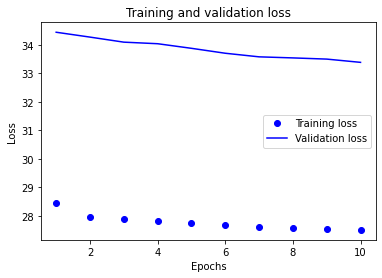

In [ ]:
entrainement_NN(NN=model_25, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_station_train, outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_model_25_build_mape = model_25.predict(X_station_test)

In [ ]:
np.mean(Y_forecast_model_25_build_mape)

0.14900567

### <u> b. lstm_2

#### Expérience 10: LSTM_2(pile de 2 couches, dropout) avec X_station, loss=mse

In [ ]:
def lstm_2():  
  inputs = Input(shape=(24, 2), name='encoder_inputs')

  x = LSTM(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, name='lstm')(inputs)
  x = LSTM(64, activation='relu', dropout=0.1, recurrent_dropout=0.5, name='lstm_2')(x)
  x = Dense(8, activation='relu')(x)
  outputs = Dense(1, activation='relu')(x)

  return Model(inputs, outputs, name='lstm_2')

In [ ]:
model_10 = lstm_2()
model_10.summary()

Model: "lstm_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 24, 2)]          0         
                                                                 
 lstm (LSTM)                 (None, 24, 32)            4480      
                                                                 
 lstm_2 (LSTM)               (None, 64)                24832     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 29,841
Trainable params: 29,841
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
1188/1188 [==============================] - 91s 72ms/step - loss: 16.4723 - mae: 2.2601 - val_loss: 17.7171 - val_mae: 2.4522
Epoch 2/10
1188/1188 [==============================] - 85s 72ms/step - loss: 15.1236 - mae: 2.2193 - val_loss: 17.4295 - val_mae: 2.4306
Epoch 3/10
1188/1188 [==============================] - 85s 72ms/step - loss: 14.7531 - mae: 2.1700 - val_loss: 17.5381 - val_mae: 2.3436
Epoch 4/10
1188/1188 [==============================] - 85s 72ms/step - loss: 14.6498 - mae: 2.1584 - val_loss: 17.5284 - val_mae: 2.3306
Epoch 5/10
1188/1188 [==============================] - 85s 72ms/step - loss: 14.5284 - mae: 2.1499 - val_loss: 17.5392 - val_mae: 2.3755
Epoch 6/10
1188/1188 [==============================] - 86s 72ms/step - loss: 14.4837 - mae: 2.1450 - val_loss: 17.3956 - val_mae: 2.2731
Epoch 7/10
1188/1188 [==============================] - 86s 72ms/step - loss: 14.3765 - mae: 2.1330 - val_loss: 17.1969 - val_mae: 2.3179
Epoch 8/10
1188/1188 [============

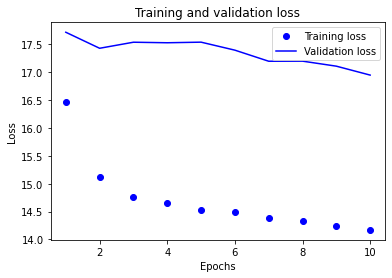

In [ ]:
entrainement_NN(NN=model_10, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='mse', 
                inputs=X_station_train, outputs=Y_train, 
                epochs=10, batch_size=100)

In [ ]:
Y_forecast_test = model_10.predict(X_station_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 72.4 %


Epoch 1/5
1188/1188 [==============================] - 91s 72ms/step - loss: 14.1565 - mae: 2.1112 - val_loss: 17.0130 - val_mae: 2.3597
Epoch 2/5
1188/1188 [==============================] - 85s 71ms/step - loss: 14.1118 - mae: 2.1066 - val_loss: 16.9161 - val_mae: 2.2712
Epoch 3/5
1188/1188 [==============================] - 85s 72ms/step - loss: 14.0454 - mae: 2.1020 - val_loss: 16.9931 - val_mae: 2.2678
Epoch 4/5
1188/1188 [==============================] - 85s 71ms/step - loss: 14.0622 - mae: 2.1013 - val_loss: 16.8935 - val_mae: 2.3233
Epoch 5/5
1188/1188 [==============================] - 85s 72ms/step - loss: 13.9863 - mae: 2.0957 - val_loss: 16.8433 - val_mae: 2.3371


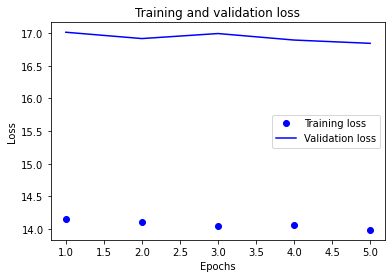

In [ ]:
# Ajout de 5 epochs
entrainement_NN(NN=model_10, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='mse', 
                inputs=X_station_train, outputs=Y_train, 
                epochs=5, batch_size=100)

In [ ]:
Y_forecast_test = model_10.predict(X_station_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 75.5 %


In [ ]:
Y_forecast_model_10_mse = model_10.predict(X_station_test)

#### Expérience 10.1: loss=build_MAPE

Epoch 1/10
594/594 [==============================] - 67s 103ms/step - loss: 28.5684 - build_MAPE: 28.5684 - val_loss: 34.8393 - val_build_MAPE: 34.8393
Epoch 2/10
594/594 [==============================] - 60s 102ms/step - loss: 28.2748 - build_MAPE: 28.2748 - val_loss: 34.5511 - val_build_MAPE: 34.5511
Epoch 3/10
594/594 [==============================] - 60s 101ms/step - loss: 28.1710 - build_MAPE: 28.1710 - val_loss: 34.5114 - val_build_MAPE: 34.5114
Epoch 4/10
594/594 [==============================] - 60s 102ms/step - loss: 28.1017 - build_MAPE: 28.1017 - val_loss: 34.4542 - val_build_MAPE: 34.4542
Epoch 5/10
594/594 [==============================] - 61s 103ms/step - loss: 28.0487 - build_MAPE: 28.0487 - val_loss: 34.4041 - val_build_MAPE: 34.4041
Epoch 6/10
594/594 [==============================] - 61s 103ms/step - loss: 27.9952 - build_MAPE: 27.9952 - val_loss: 34.3108 - val_build_MAPE: 34.3108
Epoch 7/10
594/594 [==============================] - 61s 103ms/step - loss: 27.95

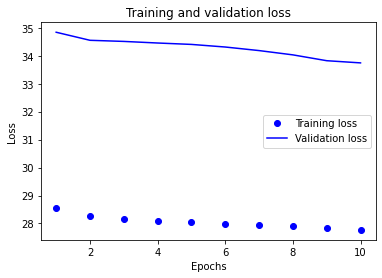

In [ ]:
entrainement_NN(NN=model_10, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_station_train, outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_test = model_10.predict(X_station_train)

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 29.0 %


In [ ]:
np.mean(Y_forecast_test)

0.13207905

In [ ]:
Y_forecast_model_10_1_build_mape = model_10.predict(X_station_test)

In [ ]:
np.mean(Y_forecast_model_10_1_build_mape)

0.11676609

#### Expérience 26: LSTM_2(pile de 2 couches) avec X_station, loss=build_MAPE

In [ ]:
def lstm_3():  
  inputs = Input(shape=(24, 2), name='encoder_inputs')

  x = LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='lstm')(inputs)
  x = LSTM(64, activation='relu', kernel_initializer='he_uniform', name='lstm_2')(x)
  x = Dense(8, activation='relu')(x)
  
  outputs = Dense(1, activation='relu')(x)

  return Model(inputs, outputs, name='lstm_3')

In [ ]:
model_26 = lstm_3()
model_26.summary()

Model: "lstm_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 24, 2)]          0         
                                                                 
 lstm (LSTM)                 (None, 24, 32)            4480      
                                                                 
 lstm_2 (LSTM)               (None, 64)                24832     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 29,841
Trainable params: 29,841
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10


KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


594/594 [==============================] - 106s 73ms/step - loss: 28.9484 - build_MAPE: 28.9484 - val_loss: 35.4820 - val_build_MAPE: 35.4820
Epoch 2/10
594/594 [==============================] - 43s 72ms/step - loss: 28.2786 - build_MAPE: 28.2786 - val_loss: 34.4344 - val_build_MAPE: 34.4344
Epoch 3/10
594/594 [==============================] - 42s 71ms/step - loss: 27.8678 - build_MAPE: 27.8678 - val_loss: 34.2161 - val_build_MAPE: 34.2161
Epoch 4/10
594/594 [==============================] - 42s 72ms/step - loss: 27.7513 - build_MAPE: 27.7513 - val_loss: 34.2551 - val_build_MAPE: 34.2551
Epoch 5/10
594/594 [==============================] - 42s 71ms/step - loss: 27.5921 - build_MAPE: 27.5921 - val_loss: 33.9607 - val_build_MAPE: 33.9607
Epoch 6/10
594/594 [==============================] - 42s 71ms/step - loss: 27.4522 - build_MAPE: 27.4522 - val_loss: 33.9137 - val_build_MAPE: 33.9137
Epoch 7/10
594/594 [==============================] - 43s 72ms/step - loss: 27.3555 - build_MAPE: 

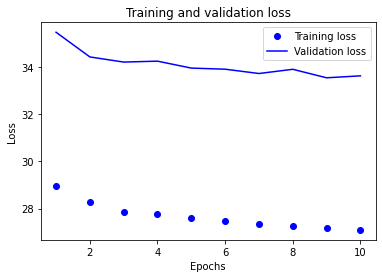

In [ ]:
entrainement_NN(NN=model_26, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_station_train, outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_model_26_build_mape = model_26.predict(X_station_test)

In [ ]:
np.mean(Y_forecast_model_26_build_mape)

0.18682307

### <u> c. lstm_3

#### Expérience 11: LSTM_3 avec X_station et X_forecast, loss=mse

In [ ]:
def lstm_3():  
  encoder_inputs = Input(shape=(24, 2), name='encoder_inputs')

  encoder_lstm = LSTM(32, return_sequences=False, name='lstm_1')(encoder_inputs)
  encoder_lstm_2 = Dense(7, activation='relu', name='dense_1')(encoder_lstm)
  encoder_lstm_3 = Reshape((1,7))(encoder_lstm_2)

  decoder_inputs = Input(shape=(24, 7), name='decoder_inputs')

  decoder_concat = Concatenate(axis=1)([encoder_lstm_3, decoder_inputs])

  decoder_lstm = LSTM(128, return_sequences=True, name='lstm_2')(decoder_concat)
  decoder_lstm_2 = Lambda(lambda x: x[:, 1:, :])(decoder_lstm)

  decoder_lstm_3 = TimeDistributed(Dense(32, activation='relu'))(decoder_lstm_2)
  decoder_lstm_4 = TimeDistributed(Dense(1, activation='relu'))(decoder_lstm_3)
  decoder_lstm_4 = Flatten()(decoder_lstm_4)

  decoder_outputs = sum(decoder_lstm_4, axis=1, keepdims=True)

  return Model([encoder_inputs, decoder_inputs], decoder_outputs, name='LSTM_3')

In [ ]:
model_11 = lstm_3()
model_11.summary()

Model: "LSTM_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 24, 2)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 32)           4480        ['encoder_inputs[0][0]']         
                                                                                                  
 dense_1 (Dense)                (None, 7)            231         ['lstm_1[0][0]']                 
                                                                                                  
 reshape_5 (Reshape)            (None, 1, 7)         0           ['dense_1[0][0]']                
                                                                                             

Epoch 1/10
1188/1188 [==============================] - 102s 82ms/step - loss: 7.5854 - mae: 1.2607 - val_loss: 8.5423 - val_mae: 1.4425
Epoch 2/10
1188/1188 [==============================] - 96s 81ms/step - loss: 6.6577 - mae: 1.1752 - val_loss: 8.1948 - val_mae: 1.4179
Epoch 3/10
1188/1188 [==============================] - 97s 82ms/step - loss: 6.4572 - mae: 1.1460 - val_loss: 8.1400 - val_mae: 1.5057
Epoch 4/10
1188/1188 [==============================] - 97s 82ms/step - loss: 6.2817 - mae: 1.1284 - val_loss: 8.3062 - val_mae: 1.4709
Epoch 5/10
1188/1188 [==============================] - 97s 81ms/step - loss: 6.1549 - mae: 1.1157 - val_loss: 8.3468 - val_mae: 1.4604
Epoch 6/10
1188/1188 [==============================] - 97s 82ms/step - loss: 6.0145 - mae: 1.1007 - val_loss: 8.3929 - val_mae: 1.4964
Epoch 7/10
1188/1188 [==============================] - 97s 82ms/step - loss: 5.8915 - mae: 1.0893 - val_loss: 8.2708 - val_mae: 1.4603
Epoch 8/10
1188/1188 [=========================

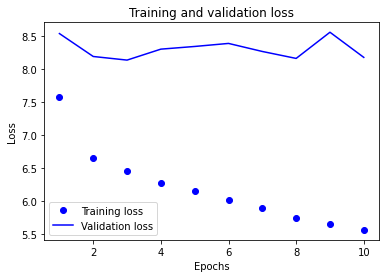

In [ ]:
entrainement_NN(NN=model_11, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='mse', 
                inputs=[X_station_train, X_forecast_train[:,:,:-4]], outputs=Y_train, 
                epochs=10, batch_size=100)

In [ ]:
Y_forecast_test = model_11.predict([X_station_train, X_forecast_train[:,:,:-4]])

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 92.4 %


In [ ]:
Y_forecast_model_11_mse = model_11.predict([X_station_test, X_forecast_test[:,:,:-4]])

#### Expérience 11.1: loss=logcosh

Epoch 1/10
594/594 [==============================] - 90s 145ms/step - loss: 0.9276 - mae: 1.2229 - val_loss: 1.0298 - val_mae: 1.3859
Epoch 2/10
594/594 [==============================] - 85s 143ms/step - loss: 0.8183 - mae: 1.1087 - val_loss: 1.0084 - val_mae: 1.3748
Epoch 3/10
594/594 [==============================] - 86s 146ms/step - loss: 0.7968 - mae: 1.0833 - val_loss: 0.9922 - val_mae: 1.3501
Epoch 4/10
594/594 [==============================] - 86s 145ms/step - loss: 0.7828 - mae: 1.0675 - val_loss: 0.9805 - val_mae: 1.3262
Epoch 5/10
594/594 [==============================] - 86s 145ms/step - loss: 0.7711 - mae: 1.0551 - val_loss: 0.9815 - val_mae: 1.3352
Epoch 6/10
594/594 [==============================] - 85s 143ms/step - loss: 0.7599 - mae: 1.0424 - val_loss: 0.9744 - val_mae: 1.3174
Epoch 7/10
594/594 [==============================] - 87s 146ms/step - loss: 0.7508 - mae: 1.0333 - val_loss: 0.9723 - val_mae: 1.3141
Epoch 8/10
594/594 [==============================] - 8

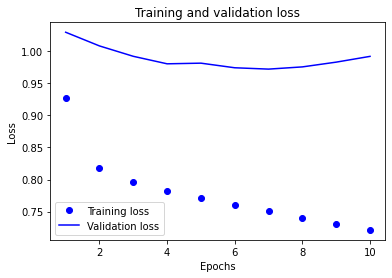

In [ ]:
entrainement_NN(NN=model_11, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='logcosh', 
                inputs=[X_station_train, X_forecast_train[:,:,:-4]], outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_test = model_11.predict([X_station_train, X_forecast_train[:,:,:-4]])

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 73.9 %


In [ ]:
Y_forecast_model_11_1_logcosh = model_11.predict([X_station_test, X_forecast_test[:,:,:-4]])

#### Expérience 11.2: loss=build_MAPE

Epoch 1/10
594/594 [==============================] - 85s 137ms/step - loss: 23.6617 - build_MAPE: 23.6617 - val_loss: 29.6043 - val_build_MAPE: 29.6043
Epoch 2/10
594/594 [==============================] - 79s 134ms/step - loss: 22.8245 - build_MAPE: 22.8245 - val_loss: 29.4294 - val_build_MAPE: 29.4294
Epoch 3/10
594/594 [==============================] - 80s 134ms/step - loss: 22.5120 - build_MAPE: 22.5120 - val_loss: 28.8364 - val_build_MAPE: 28.8364
Epoch 4/10
594/594 [==============================] - 80s 134ms/step - loss: 22.2524 - build_MAPE: 22.2524 - val_loss: 29.0191 - val_build_MAPE: 29.0191
Epoch 5/10
594/594 [==============================] - 80s 134ms/step - loss: 22.0705 - build_MAPE: 22.0705 - val_loss: 29.2445 - val_build_MAPE: 29.2445
Epoch 6/10
594/594 [==============================] - 80s 135ms/step - loss: 21.9061 - build_MAPE: 21.9061 - val_loss: 28.6160 - val_build_MAPE: 28.6160
Epoch 7/10
594/594 [==============================] - 80s 135ms/step - loss: 21.77

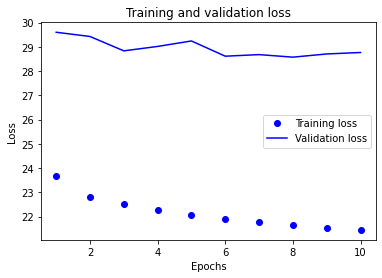

In [ ]:
entrainement_NN(NN=model_11, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=[X_station_train, X_forecast_train[:,:,:-4]], outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_test = model_11.predict([X_station_train, X_forecast_train[:,:,:-4]])

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 50.5 %


In [ ]:
np.mean(Y_forecast_test)

0.9295038

In [ ]:
Y_forecast_model_11_2_build_mape = model_11.predict([X_station_test, X_forecast_test[:,:,:-4]])

In [ ]:
np.mean(Y_forecast_model_11_2_build_mape)

0.93339616

#### Expérience 12: LSTM_3(dropout) avec X_station et X_forecast, loss=build_MAPE

In [ ]:
def lstm_3_1():  
  encoder_inputs = Input(shape=(24, 2), name='encoder_inputs')

  encoder_lstm = LSTM(32, dropout=0.2,recurrent_dropout=0.2, return_sequences=False, name='lstm_1')(encoder_inputs)
  encoder_lstm_2 = Dense(7, activation='relu', name='dense_1')(encoder_lstm)
  encoder_lstm_3 = Reshape((1,7))(encoder_lstm_2)

  decoder_inputs = Input(shape=(24, 7), name='decoder_inputs')

  decoder_concat = Concatenate(axis=1)([encoder_lstm_3, decoder_inputs])

  decoder_lstm = LSTM(128,dropout=0.2, recurrent_dropout=0.2, return_sequences=True, name='lstm_2')(decoder_concat)
  decoder_lstm_2 = Lambda(lambda x: x[:, 1:, :])(decoder_lstm)

  decoder_lstm_3 = TimeDistributed(Dense(32, activation='relu'))(decoder_lstm_2)
  decoder_lstm_4 = TimeDistributed(Dense(1, activation='relu'))(decoder_lstm_3)
  decoder_lstm_4 = Flatten()(decoder_lstm_4)

  decoder_outputs = sum(decoder_lstm_4, axis=1, keepdims=True)

  return Model([encoder_inputs, decoder_inputs], decoder_outputs, name='LSTM_3_1')

In [ ]:
model_12 = lstm_3_1()
model_12.summary()

Model: "LSTM_3_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 24, 2)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 32)           4480        ['encoder_inputs[0][0]']         
                                                                                                  
 dense_1 (Dense)                (None, 7)            231         ['lstm_1[0][0]']                 
                                                                                                  
 reshape (Reshape)              (None, 1, 7)         0           ['dense_1[0][0]']                
                                                                                           

Epoch 1/10
594/594 [==============================] - 130s 209ms/step - loss: 24.3191 - build_MAPE: 24.3191 - val_loss: 29.7050 - val_build_MAPE: 29.7050
Epoch 2/10
594/594 [==============================] - 123s 207ms/step - loss: 23.0952 - build_MAPE: 23.0952 - val_loss: 29.2541 - val_build_MAPE: 29.2541
Epoch 3/10
594/594 [==============================] - 123s 206ms/step - loss: 22.8685 - build_MAPE: 22.8685 - val_loss: 28.8884 - val_build_MAPE: 28.8884
Epoch 4/10
594/594 [==============================] - 123s 207ms/step - loss: 22.6906 - build_MAPE: 22.6906 - val_loss: 28.8692 - val_build_MAPE: 28.8692
Epoch 5/10
594/594 [==============================] - 123s 208ms/step - loss: 22.5232 - build_MAPE: 22.5232 - val_loss: 29.1079 - val_build_MAPE: 29.1079
Epoch 6/10
594/594 [==============================] - 123s 207ms/step - loss: 22.4277 - build_MAPE: 22.4277 - val_loss: 29.0457 - val_build_MAPE: 29.0457
Epoch 7/10
594/594 [==============================] - 123s 207ms/step - loss

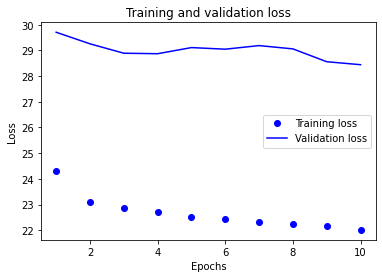

In [ ]:
entrainement_NN(NN=model_12, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=[X_station_train, X_forecast_train[:,:,:-4]], outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_test = model_12.predict([X_station_train, X_forecast_train[:,:,:-4]])

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 94.1 %


In [ ]:
Y_forecast_model_12_build_mape = model_12.predict([X_station_test, X_forecast_test[:,:,:-4]])

In [ ]:
np.mean(Y_forecast_model_12_build_mape)

0.8438832

### d. lstm_4

#### Expérience 13: LSTM_4 avec X_forecast, loss=mse

In [ ]:
def lstm_4():  
  decoder_inputs = Input(shape=(24, 7), name='decoder_inputs')

  decoder_lstm = LSTM(64, return_sequences=True, name='lstm')(decoder_inputs)
  decoder_lstm = TimeDistributed(Dense(16, activation='relu'))(decoder_lstm)
  decoder_lstm = TimeDistributed(Dense(1, activation='relu'))(decoder_lstm)
  decoder_lstm = Flatten()(decoder_lstm)

  decoder_outputs = sum(decoder_lstm, axis=1, keepdims=True)

  return Model(decoder_inputs, decoder_outputs, name='LSTM_4')

In [ ]:
model_13 = lstm_4()
model_13.summary()

Model: "LSTM_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_inputs (InputLayer)  [(None, 24, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 24, 64)            18432     
                                                                 
 time_distributed (TimeDistr  (None, 24, 16)           1040      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 24, 1)            17        
 tributed)                                                       
                                                                 
 flatten_4 (Flatten)         (None, 24)                0         
                                                                 
 tf.math.reduce_sum (TFOpLam  (None, 1)                0    

Epoch 1/10
1188/1188 [==============================] - 33s 26ms/step - loss: 7.8263 - mae: 1.2970 - val_loss: 8.9652 - val_mae: 1.4838
Epoch 2/10
1188/1188 [==============================] - 30s 25ms/step - loss: 6.9417 - mae: 1.2085 - val_loss: 8.6246 - val_mae: 1.4511
Epoch 3/10
1188/1188 [==============================] - 30s 25ms/step - loss: 6.6587 - mae: 1.1763 - val_loss: 8.3938 - val_mae: 1.4984
Epoch 4/10
1188/1188 [==============================] - 30s 25ms/step - loss: 6.5018 - mae: 1.1579 - val_loss: 8.4331 - val_mae: 1.5264
Epoch 5/10
1188/1188 [==============================] - 30s 25ms/step - loss: 6.3754 - mae: 1.1414 - val_loss: 8.3145 - val_mae: 1.4490
Epoch 6/10
1188/1188 [==============================] - 30s 25ms/step - loss: 6.2899 - mae: 1.1311 - val_loss: 8.2920 - val_mae: 1.3932
Epoch 7/10
1188/1188 [==============================] - 30s 25ms/step - loss: 6.2033 - mae: 1.1194 - val_loss: 8.3688 - val_mae: 1.4340
Epoch 8/10
1188/1188 [==========================

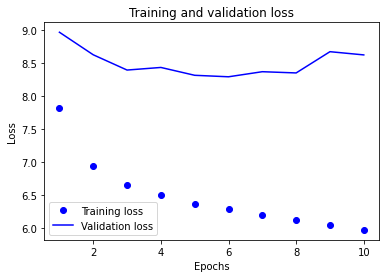

In [ ]:
entrainement_NN(NN=model_13, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='mse', 
                inputs=X_forecast_train[:,:,:-4], outputs=Y_train, 
                epochs=10, batch_size=100)

In [ ]:
Y_forecast_test = model_13.predict(X_forecast_train[:,:,:-4])

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 91.4 %


In [ ]:
Y_forecast_model_13_mse = model_13.predict(X_forecast_test[:,:,:-4])

#### Expérience 13.2: loss=logcosh

Epoch 1/10
1188/1188 [==============================] - 33s 26ms/step - loss: 0.9496 - mae: 1.2635 - val_loss: 1.0371 - val_mae: 1.3909
Epoch 2/10
1188/1188 [==============================] - 30s 25ms/step - loss: 0.8262 - mae: 1.1138 - val_loss: 1.0085 - val_mae: 1.3467
Epoch 3/10
1188/1188 [==============================] - 30s 25ms/step - loss: 0.8055 - mae: 1.0894 - val_loss: 1.0117 - val_mae: 1.3634
Epoch 4/10
1188/1188 [==============================] - 30s 25ms/step - loss: 0.7932 - mae: 1.0759 - val_loss: 1.0000 - val_mae: 1.3553
Epoch 5/10
1188/1188 [==============================] - 30s 25ms/step - loss: 0.7827 - mae: 1.0642 - val_loss: 0.9974 - val_mae: 1.3435
Epoch 6/10
1188/1188 [==============================] - 30s 25ms/step - loss: 0.7740 - mae: 1.0542 - val_loss: 0.9861 - val_mae: 1.3343
Epoch 7/10
1188/1188 [==============================] - 30s 25ms/step - loss: 0.7654 - mae: 1.0453 - val_loss: 0.9776 - val_mae: 1.3171
Epoch 8/10
1188/1188 [==========================

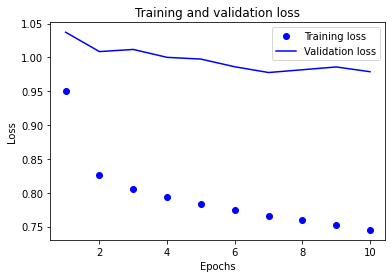

In [ ]:
entrainement_NN(NN=model_13, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='logcosh', 
                inputs=X_forecast_train[:,:,:-4], outputs=Y_train, 
                epochs=10, batch_size=100)

In [ ]:
Y_forecast_test = model_13.predict(X_forecast_train[:,:,:-4])

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 74.2 %


In [ ]:
Y_forecast_model_13_1_logcosh = model_13.predict(X_forecast_test[:,:,:-4])

#### Expérience 13.3: loss=mse, batch_size=500

Model: "LSTM_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_inputs (InputLayer)  [(None, 24, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 24, 64)            18432     
                                                                 
 time_distributed_12 (TimeDi  (None, 24, 16)           1040      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 24, 1)            17        
 stributed)                                                      
                                                                 
 flatten_13 (Flatten)        (None, 24)                0         
                                                                 
 tf.math.reduce_sum_5 (TFOpL  (None, 1)                0    

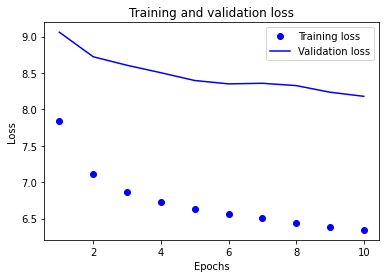

In [ ]:
model_13 = lstm_4()
model_13.summary()

entrainement_NN(NN=model_13, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='mse', 
                inputs=X_forecast_train[:,:,:-4], outputs=Y_train, 
                epochs=10, batch_size=500)

In [ ]:
Y_forecast_test = model_13.predict(X_forecast_train[:,:,:-4])

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 97.8 %


In [ ]:
Y_forecast_model_13_3_mse = model_13.predict(X_forecast_test[:,:,:-4])

#### Expérience 13.4: loss=logcosh, batch_size=500

Model: "LSTM_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_inputs (InputLayer)  [(None, 24, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 24, 64)            18432     
                                                                 
 time_distributed_14 (TimeDi  (None, 24, 16)           1040      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 24, 1)            17        
 stributed)                                                      
                                                                 
 flatten_14 (Flatten)        (None, 24)                0         
                                                                 
 tf.math.reduce_sum_6 (TFOpL  (None, 1)                0    

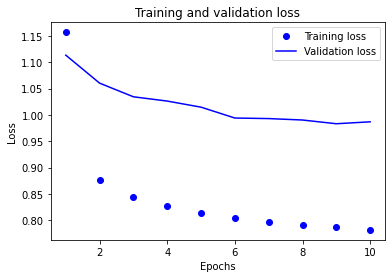

In [ ]:
entrainement_NN(NN=model_13, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='logcosh', 
                inputs=X_forecast_train[:,:,:-4], outputs=Y_train, 
                epochs=10, batch_size=500)

In [ ]:
Y_forecast_test = model_13.predict(X_forecast_train[:,:,:-4])

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 77.2 %


In [ ]:
Y_forecast_model_13_4_logcosh = model_13.predict(X_forecast_test[:,:,:-4])

#### Expérience 13.5: loss=build_MAPE, batch_size=200

Epoch 1/10
594/594 [==============================] - 30s 48ms/step - loss: 29.1852 - build_MAPE: 29.1852 - val_loss: 30.6182 - val_build_MAPE: 30.6182
Epoch 2/10
594/594 [==============================] - 28s 47ms/step - loss: 23.6324 - build_MAPE: 23.6324 - val_loss: 30.1004 - val_build_MAPE: 30.1004
Epoch 3/10
594/594 [==============================] - 28s 47ms/step - loss: 23.0897 - build_MAPE: 23.0897 - val_loss: 29.6836 - val_build_MAPE: 29.6836
Epoch 4/10
594/594 [==============================] - 28s 47ms/step - loss: 22.7423 - build_MAPE: 22.7423 - val_loss: 29.3871 - val_build_MAPE: 29.3871
Epoch 5/10
594/594 [==============================] - 28s 47ms/step - loss: 22.5195 - build_MAPE: 22.5195 - val_loss: 29.4657 - val_build_MAPE: 29.4657
Epoch 6/10
594/594 [==============================] - 28s 47ms/step - loss: 22.3953 - build_MAPE: 22.3953 - val_loss: 29.3305 - val_build_MAPE: 29.3305
Epoch 7/10
594/594 [==============================] - 28s 47ms/step - loss: 22.2865 - bu

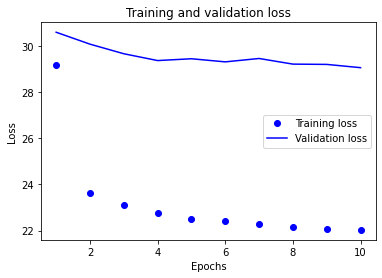

In [ ]:
entrainement_NN(NN=model_13, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_forecast_train[:,:,:-4], outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_test = model_13.predict(X_forecast_train[:,:,:-4])

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 48.2 %


In [ ]:
np.mean(Y_forecast_test)

0.81879216

In [ ]:
Y_forecast_model_13_5_build_mape = model_13.predict(X_forecast_test[:,:,:-4])

In [ ]:
np.mean(Y_forecast_model_13_5_build_mape)

0.8272183

### e. lstm_5

#### Expérience 20: LSTM_5 avec X_forecast, loss=build_MAPE

In [ ]:
def lstm_5():  
  decoder_inputs = Input(shape=(24, 7), name='decoder_inputs')

  decoder_lstm = LSTM(32, return_sequences=True, name='lstm')(decoder_inputs)
  decoder_lstm = TimeDistributed(Dense(16, activation='relu'))(decoder_lstm)
  decoder_lstm = TimeDistributed(Dense(1, activation='relu'))(decoder_lstm)
  decoder_lstm = Flatten()(decoder_lstm)

  decoder_outputs = sum(decoder_lstm, axis=1, keepdims=True)

  return Model(decoder_inputs, decoder_outputs, name='LSTM_5')

In [ ]:
model_20 = lstm_5()
model_20.summary()

Model: "LSTM_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_inputs (InputLayer)  [(None, 24, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 24, 32)            5120      
                                                                 
 time_distributed_12 (TimeDi  (None, 24, 16)           528       
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 24, 1)            17        
 stributed)                                                      
                                                                 
 flatten_10 (Flatten)        (None, 24)                0         
                                                                 
 tf.math.reduce_sum_4 (TFOpL  (None, 1)                0    

Epoch 1/10
594/594 [==============================] - 17s 24ms/step - loss: 26.0501 - build_MAPE: 26.0501 - val_loss: 31.3746 - val_build_MAPE: 31.3746
Epoch 2/10
594/594 [==============================] - 14s 23ms/step - loss: 24.1066 - build_MAPE: 24.1066 - val_loss: 31.0431 - val_build_MAPE: 31.0431
Epoch 3/10
594/594 [==============================] - 14s 23ms/step - loss: 23.6385 - build_MAPE: 23.6385 - val_loss: 30.4270 - val_build_MAPE: 30.4270
Epoch 4/10
594/594 [==============================] - 14s 24ms/step - loss: 23.3058 - build_MAPE: 23.3058 - val_loss: 30.1596 - val_build_MAPE: 30.1596
Epoch 5/10
594/594 [==============================] - 14s 24ms/step - loss: 23.0870 - build_MAPE: 23.0870 - val_loss: 29.7567 - val_build_MAPE: 29.7567
Epoch 6/10
594/594 [==============================] - 14s 23ms/step - loss: 22.9111 - build_MAPE: 22.9111 - val_loss: 29.6303 - val_build_MAPE: 29.6303
Epoch 7/10
594/594 [==============================] - 14s 23ms/step - loss: 22.7655 - bu

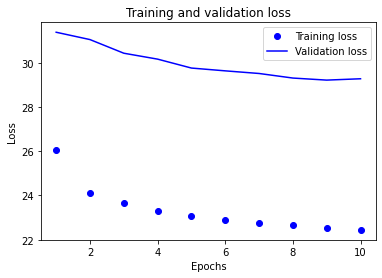

In [ ]:
entrainement_NN(NN=model_20, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_forecast_train[:,:,:-4], outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_model_20_build_mape = model_20.predict(X_forecast_test[:,:,:-4])

In [ ]:
np.mean(Y_forecast_model_20_build_mape)

0.7792565

## 3.3. Entraînement et évaluation d'un modèle U-LSTM.

#### Expérience 14: U-LSTM avec X_station et X_forecast, loss=logcosh

In [ ]:
def U_lstm():  
  encoder_inputs = Input(shape=(24, 2), name='encoder_inputs')

  encoder_lstm_1 = LSTM(16, return_sequences=True, name='lstm_1')(encoder_inputs)
  outputs_lstm_1 = Lambda(lambda x: x[:, -1, :])(encoder_lstm_1)
  outputs_lstm_1 = Dense(7, activation='relu', name='dense_1')(outputs_lstm_1)
  outputs_lstm_1 = Reshape((1,7))(outputs_lstm_1)

  decoder_inputs = Input(shape=(24, 7), name='decoder_inputs')

  inputs_lstm_2 = Concatenate(axis=1)([outputs_lstm_1, decoder_inputs])

  decoder_lstm_2 = LSTM(32, return_sequences=True, name='lstm_2')(inputs_lstm_2)
  decoder_lstm_2 = Lambda(lambda x: x[:, 1:, :])(decoder_lstm_2)
  decoder_lstm_2 = TimeDistributed(Dense(16, activation='relu'))(decoder_lstm_2)

  encoder_lstm_3 = Concatenate(axis=1)([encoder_lstm_1, decoder_lstm_2])

  decoder_lstm_3 = tf.keras.layers.Bidirectional(LSTM(32))(encoder_lstm_3)
  decoder_lstm_3 = Dense(8, activation='relu', name='dense_2')(decoder_lstm_3)
  decoder_outputs = Dense(1, activation='relu', name='dense_3')(decoder_lstm_3)

  return Model([encoder_inputs, decoder_inputs], decoder_outputs, name='U_LSTM')

In [ ]:
model_14 = U_lstm()
model_14.summary()

Model: "U_LSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 24, 2)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 24, 16)       1216        ['encoder_inputs[0][0]']         
                                                                                                  
 lambda_10 (Lambda)             (None, 16)           0           ['lstm_1[0][0]']                 
                                                                                                  
 dense_1 (Dense)                (None, 7)            119         ['lambda_10[0][0]']              
                                                                                             

Epoch 1/10
1188/1188 [==============================] - 107s 84ms/step - loss: 0.9762 - mae: 1.2827 - val_loss: 1.0256 - val_mae: 1.3786
Epoch 2/10
1188/1188 [==============================] - 97s 82ms/step - loss: 0.8092 - mae: 1.1013 - val_loss: 0.9944 - val_mae: 1.3380
Epoch 3/10
1188/1188 [==============================] - 98s 83ms/step - loss: 0.7900 - mae: 1.0790 - val_loss: 0.9790 - val_mae: 1.3284
Epoch 4/10
1188/1188 [==============================] - 98s 82ms/step - loss: 0.7761 - mae: 1.0636 - val_loss: 0.9820 - val_mae: 1.3282
Epoch 5/10
1188/1188 [==============================] - 98s 83ms/step - loss: 0.7644 - mae: 1.0505 - val_loss: 0.9722 - val_mae: 1.3099
Epoch 6/10
1188/1188 [==============================] - 101s 85ms/step - loss: 0.7534 - mae: 1.0388 - val_loss: 0.9623 - val_mae: 1.3129
Epoch 7/10
1188/1188 [==============================] - 99s 83ms/step - loss: 0.7436 - mae: 1.0278 - val_loss: 0.9496 - val_mae: 1.3021
Epoch 8/10
1188/1188 [========================

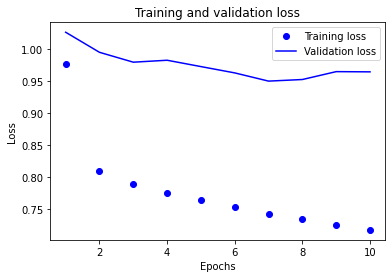

In [ ]:
entrainement_NN(NN=model_14, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='logcosh', 
                inputs=[X_station_train, X_forecast_train[:,:,:-4]], outputs=Y_train, 
                epochs=10, batch_size=100)

In [ ]:
Y_forecast_test = model_14.predict([X_station_train, X_forecast_train[:,:,:-4]])

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 78.9 %


In [ ]:
Y_forecast_model_14_logcosh = model_14.predict([X_station_test, X_forecast_test[:,:,:-4]])

#### Expérience 14.1: batch_size=1000

Epoch 1/10
119/119 [==============================] - 66s 489ms/step - loss: 1.5212 - mae: 1.8162 - val_loss: 1.6598 - val_mae: 2.0204
Epoch 2/10
119/119 [==============================] - 56s 474ms/step - loss: 1.3026 - mae: 1.6397 - val_loss: 1.3472 - val_mae: 1.7239
Epoch 3/10
119/119 [==============================] - 56s 468ms/step - loss: 1.0707 - mae: 1.3717 - val_loss: 1.1845 - val_mae: 1.5419
Epoch 4/10
119/119 [==============================] - 55s 466ms/step - loss: 0.9856 - mae: 1.2789 - val_loss: 1.1327 - val_mae: 1.4861
Epoch 5/10
119/119 [==============================] - 56s 469ms/step - loss: 0.9419 - mae: 1.2326 - val_loss: 1.1004 - val_mae: 1.4509
Epoch 6/10
119/119 [==============================] - 56s 468ms/step - loss: 0.9124 - mae: 1.2023 - val_loss: 1.0779 - val_mae: 1.4267
Epoch 7/10
119/119 [==============================] - 55s 466ms/step - loss: 0.8900 - mae: 1.1779 - val_loss: 1.0624 - val_mae: 1.4127
Epoch 8/10
119/119 [==============================] - 5

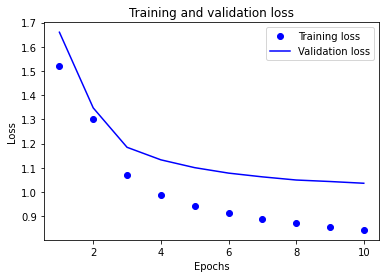

In [ ]:
entrainement_NN(NN=model_14, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='logcosh', 
                inputs=[X_station_train, X_forecast_train[:,:,:-4]], outputs=Y_train, 
                epochs=10, batch_size=1000)

In [ ]:
Y_forecast_test = model_14.predict([X_station_train, X_forecast_train[:,:,:-4]])

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 72.4 %


In [ ]:
Y_forecast_model_14_1_logcosh = model_14.predict([X_station_test, X_forecast_test[:,:,:-4]])

Epoch 1/10
119/119 [==============================] - 70s 518ms/step - loss: 0.8316 - mae: 1.1156 - val_loss: 1.0315 - val_mae: 1.3855
Epoch 2/10
119/119 [==============================] - 57s 480ms/step - loss: 0.8213 - mae: 1.1048 - val_loss: 1.0243 - val_mae: 1.3764
Epoch 3/10
119/119 [==============================] - 58s 488ms/step - loss: 0.8134 - mae: 1.0964 - val_loss: 1.0232 - val_mae: 1.3833
Epoch 4/10
119/119 [==============================] - 58s 485ms/step - loss: 0.8063 - mae: 1.0889 - val_loss: 1.0188 - val_mae: 1.3785
Epoch 5/10
119/119 [==============================] - 58s 489ms/step - loss: 0.8005 - mae: 1.0829 - val_loss: 1.0215 - val_mae: 1.3797
Epoch 6/10
119/119 [==============================] - 58s 484ms/step - loss: 0.7946 - mae: 1.0760 - val_loss: 1.0122 - val_mae: 1.3589
Epoch 7/10
119/119 [==============================] - 57s 478ms/step - loss: 0.7892 - mae: 1.0703 - val_loss: 1.0098 - val_mae: 1.3667
Epoch 8/10
119/119 [==============================] - 5

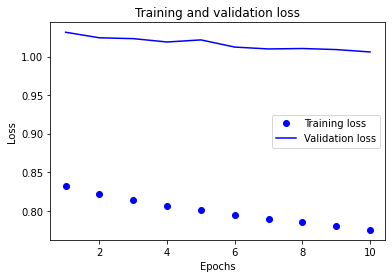

In [ ]:
entrainement_NN(NN=model_14,          # 10 epochs de plus
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss='logcosh', 
                inputs=[X_station_train, X_forecast_train[:,:,:-4]], outputs=Y_train, 
                epochs=10, batch_size=1000)

In [ ]:
Y_forecast_test = model_14.predict([X_station_train, X_forecast_train[:,:,:-4]])

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 73.4 %


In [ ]:
Y_forecast_model_14_1_logcosh = model_14.predict([X_station_test, X_forecast_test[:,:,:-4]])

#### Expérience 14.2: loss=build_MAPE

Epoch 1/10
594/594 [==============================] - 77s 117ms/step - loss: 26.1255 - build_MAPE: 26.1255 - val_loss: 29.4724 - val_build_MAPE: 29.4724
Epoch 2/10
594/594 [==============================] - 68s 114ms/step - loss: 23.5459 - build_MAPE: 23.5459 - val_loss: 29.2561 - val_build_MAPE: 29.2561
Epoch 3/10
594/594 [==============================] - 68s 115ms/step - loss: 23.0104 - build_MAPE: 23.0104 - val_loss: 29.1689 - val_build_MAPE: 29.1689
Epoch 4/10
594/594 [==============================] - 69s 115ms/step - loss: 22.6410 - build_MAPE: 22.6410 - val_loss: 29.0154 - val_build_MAPE: 29.0154
Epoch 5/10
594/594 [==============================] - 69s 116ms/step - loss: 22.3508 - build_MAPE: 22.3508 - val_loss: 28.6366 - val_build_MAPE: 28.6366
Epoch 6/10
594/594 [==============================] - 68s 115ms/step - loss: 22.1079 - build_MAPE: 22.1079 - val_loss: 28.4555 - val_build_MAPE: 28.4555
Epoch 7/10
594/594 [==============================] - 68s 115ms/step - loss: 21.92

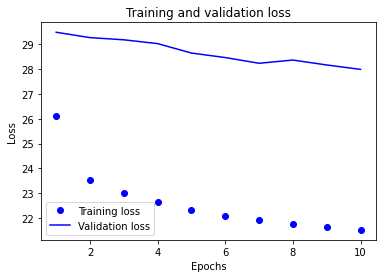

In [ ]:
entrainement_NN(NN=model_14, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=[X_station_train, X_forecast_train[:,:,:-4]], outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_test = model_14.predict([X_station_train, X_forecast_train[:,:,:-4]])

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 50.1 %


In [ ]:
np.mean(Y_forecast_test)

0.8748299

In [ ]:
Y_forecast_model_14_2_build_mape = model_14.predict([X_station_test, X_forecast_test[:,:,:-4]])

In [ ]:
np.mean(Y_forecast_model_14_2_build_mape)

0.7668703

#### Expérience 15: U-LSTM(dropout) avec X_station et X_forecast), loss=build_MAPE

In [ ]:
def U_lstm_2():  
  encoder_inputs = Input(shape=(24, 2), name='encoder_inputs')

  encoder_lstm_1 = LSTM(16, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, name='lstm_1')(encoder_inputs)
  outputs_lstm_1 = Lambda(lambda x: x[:, -1, :])(encoder_lstm_1)
  outputs_lstm_1 = Dense(7, activation='relu', name='dense_1')(outputs_lstm_1)
  outputs_lstm_1 = Reshape((1,7))(outputs_lstm_1)

  decoder_inputs = Input(shape=(24, 7), name='decoder_inputs')

  inputs_lstm_2 = Concatenate(axis=1)([outputs_lstm_1, decoder_inputs])

  decoder_lstm_2 = LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, name='lstm_2')(inputs_lstm_2)
  decoder_lstm_2 = Lambda(lambda x: x[:, 1:, :])(decoder_lstm_2)
  decoder_lstm_2 = TimeDistributed(Dense(16, activation='relu'))(decoder_lstm_2)

  encoder_lstm_3 = Concatenate(axis=1)([encoder_lstm_1, decoder_lstm_2])

  decoder_lstm_3 = tf.keras.layers.Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2))(encoder_lstm_3)
  decoder_lstm_3 = Dense(8, activation='relu', name='dense_2')(decoder_lstm_3)
  decoder_outputs = Dense(1, activation='relu', name='dense_3')(decoder_lstm_3)

  return Model([encoder_inputs, decoder_inputs], decoder_outputs, name='U_LSTM2')

In [ ]:
model_15 = U_lstm_2()
model_15.summary()

Model: "U_LSTM2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 24, 2)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 24, 16)       1216        ['encoder_inputs[0][0]']         
                                                                                                  
 lambda_7 (Lambda)              (None, 16)           0           ['lstm_1[0][0]']                 
                                                                                                  
 dense_1 (Dense)                (None, 7)            119         ['lambda_7[0][0]']               
                                                                                            

Epoch 1/10
594/594 [==============================] - 141s 219ms/step - loss: 25.4811 - build_MAPE: 25.4811 - val_loss: 29.4658 - val_build_MAPE: 29.4658
Epoch 2/10
594/594 [==============================] - 128s 216ms/step - loss: 23.6618 - build_MAPE: 23.6618 - val_loss: 29.0258 - val_build_MAPE: 29.0258
Epoch 3/10
594/594 [==============================] - 128s 216ms/step - loss: 23.2437 - build_MAPE: 23.2437 - val_loss: 28.9065 - val_build_MAPE: 28.9065
Epoch 4/10
594/594 [==============================] - 128s 216ms/step - loss: 23.0105 - build_MAPE: 23.0105 - val_loss: 28.6579 - val_build_MAPE: 28.6579
Epoch 5/10
594/594 [==============================] - 128s 216ms/step - loss: 22.7563 - build_MAPE: 22.7563 - val_loss: 28.4607 - val_build_MAPE: 28.4607
Epoch 6/10
594/594 [==============================] - 129s 217ms/step - loss: 22.5773 - build_MAPE: 22.5773 - val_loss: 28.4941 - val_build_MAPE: 28.4941
Epoch 7/10
594/594 [==============================] - 128s 216ms/step - loss

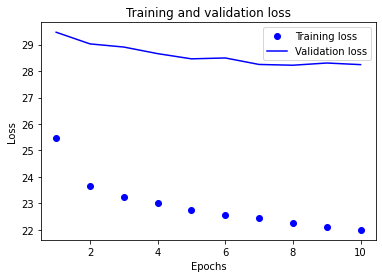

In [ ]:
entrainement_NN(NN=model_15, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=[X_station_train, X_forecast_train[:,:,:-4]], outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_model_15_build_mape = model_15.predict([X_station_test, X_forecast_test[:,:,:-4]])

In [ ]:
np.mean(Y_forecast_model_15_build_mape)

0.93644845

## 3.4. Entraînement et évaluation d'un modèle Conv1D.

### Expérience 16: Conv1D avec X_station et X_forecast, loss=build_MAPE

In [ ]:
def Convolution():
  inputs = Input(shape=(24,2), name='inputs')
  inputs_2 = Input(shape=(24,7), name='inputs_2')
  x = Concatenate(axis=2)([inputs, inputs_2])
  x = Conv1D(32,7, activation='relu')(x)
  x = MaxPooling1D(2)(x)
  x = Conv1D(32,7, activation='relu')(x)
  x = tf.keras.layers.GlobalMaxPooling1D()(x)
  outputs = Dense(1, activation='relu', name='dense_6')(x)
  return Model([inputs, inputs_2], outputs, name='Convolution')

In [ ]:
model_16 = Convolution()
model_16.summary()

Model: "Convolution"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 24, 2)]      0           []                               
                                                                                                  
 inputs_2 (InputLayer)          [(None, 24, 7)]      0           []                               
                                                                                                  
 concatenate_16 (Concatenate)   (None, 24, 9)        0           ['inputs[0][0]',                 
                                                                  'inputs_2[0][0]']               
                                                                                                  
 conv1d_26 (Conv1D)             (None, 18, 32)       2048        ['concatenate_16[0][0]'

Epoch 1/10
594/594 [==============================] - 7s 10ms/step - loss: 25.1702 - build_MAPE: 25.1702 - val_loss: 29.4372 - val_build_MAPE: 29.4372
Epoch 2/10
594/594 [==============================] - 6s 10ms/step - loss: 23.3057 - build_MAPE: 23.3057 - val_loss: 29.1711 - val_build_MAPE: 29.1711
Epoch 3/10
594/594 [==============================] - 6s 9ms/step - loss: 22.9800 - build_MAPE: 22.9800 - val_loss: 29.0718 - val_build_MAPE: 29.0718
Epoch 4/10
594/594 [==============================] - 6s 9ms/step - loss: 22.7782 - build_MAPE: 22.7782 - val_loss: 28.9642 - val_build_MAPE: 28.9642
Epoch 5/10
594/594 [==============================] - 6s 9ms/step - loss: 22.6155 - build_MAPE: 22.6155 - val_loss: 28.8998 - val_build_MAPE: 28.8998
Epoch 6/10
594/594 [==============================] - 6s 9ms/step - loss: 22.4894 - build_MAPE: 22.4894 - val_loss: 28.9022 - val_build_MAPE: 28.9022
Epoch 7/10
594/594 [==============================] - 5s 9ms/step - loss: 22.3755 - build_MAPE: 22

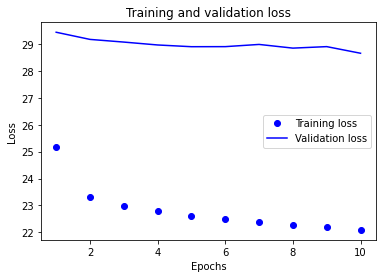

In [ ]:
entrainement_NN(NN=model_16, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=[X_station_train, X_forecast_train[:,:,:-4]], outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_test = model_16.predict([X_station_train, X_forecast_train[:,:,:-4]])

MAPE = round(float(100/len(Y_train) * sum(np.abs((Y_train-Y_forecast_test)/(Y_train+1)))), 1)
print("MAPE =", MAPE, "%")

MAPE = 46.4 %


In [ ]:
np.mean(Y_forecast_test)

0.8188852

In [ ]:
Y_forecast_model_16_build_mape = model_16.predict([X_station_test, X_forecast_test[:,:,:-4]])

In [ ]:
np.mean(Y_forecast_model_16_build_mape)

0.787892

### Expérience 19: Conv1D avec X_station et X_forecast avec prédicteurs constants, loss=build_MAPE

In [ ]:
def Convolution_2():
  inputs = Input(shape=(24,2), name='inputs')
  inputs_2 = Input(shape=(24,11), name='inputs_2')
  x = Concatenate(axis=2)([inputs, inputs_2])
  x = Conv1D(32,7, activation='relu')(x)
  x = MaxPooling1D(2)(x)
  x = Conv1D(32,7, activation='relu')(x)
  x = tf.keras.layers.GlobalMaxPooling1D()(x)
  outputs = Dense(1, activation='relu', name='dense_6')(x)
  return Model([inputs, inputs_2], outputs, name='Convolution_2')

In [ ]:
model_19 = Convolution_2()
model_19.summary()

Model: "Convolution_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 24, 2)]      0           []                               
                                                                                                  
 inputs_2 (InputLayer)          [(None, 24, 11)]     0           []                               
                                                                                                  
 concatenate_11 (Concatenate)   (None, 24, 13)       0           ['inputs[0][0]',                 
                                                                  'inputs_2[0][0]']               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 18, 32)       2944        ['concatenate_11[0][0

Epoch 1/10
594/594 [==============================] - 7s 10ms/step - loss: 27.6372 - build_MAPE: 27.6372 - val_loss: 29.9411 - val_build_MAPE: 29.9411
Epoch 2/10
594/594 [==============================] - 6s 10ms/step - loss: 23.4567 - build_MAPE: 23.4567 - val_loss: 29.7759 - val_build_MAPE: 29.7759
Epoch 3/10
594/594 [==============================] - 6s 10ms/step - loss: 23.1095 - build_MAPE: 23.1095 - val_loss: 29.8926 - val_build_MAPE: 29.8926
Epoch 4/10
594/594 [==============================] - 6s 10ms/step - loss: 22.8346 - build_MAPE: 22.8346 - val_loss: 29.6480 - val_build_MAPE: 29.6480
Epoch 5/10
594/594 [==============================] - 6s 10ms/step - loss: 22.6265 - build_MAPE: 22.6265 - val_loss: 29.6283 - val_build_MAPE: 29.6283
Epoch 6/10
594/594 [==============================] - 6s 10ms/step - loss: 22.4570 - build_MAPE: 22.4570 - val_loss: 29.8360 - val_build_MAPE: 29.8360
Epoch 7/10
594/594 [==============================] - 6s 10ms/step - loss: 22.2961 - build_MAP

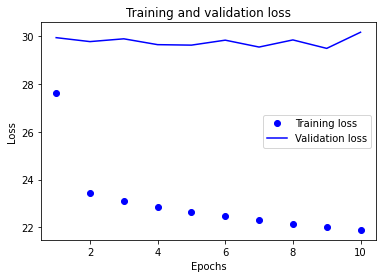

In [ ]:
entrainement_NN(NN=model_19, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=[X_station_train, X_forecast_train], outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_model_19_build_mape = model_19.predict([X_station_test, X_forecast_test])

In [ ]:
np.mean(Y_forecast_model_19_build_mape)

0.8676376

### Expérience 21: Conv1D avec X_station, loss=build_MAPE

In [ ]:
def Convolution_3():
  inputs = Input(shape=(24,2), name='inputs')
  x = Conv1D(32,7, activation='relu')(inputs)
  x = MaxPooling1D(2)(x)
  x = Conv1D(32,7, activation='relu')(x)
  x = tf.keras.layers.GlobalMaxPooling1D()(x)
  outputs = Dense(1, activation='relu', name='dense_6')(x)
  return Model(inputs, outputs, name='Convolution_3')

In [ ]:
model_21 = Convolution_3()
model_21.summary()

Model: "Convolution_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 24, 2)]           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 18, 32)            480       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 9, 32)            0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 3, 32)             7200      
                                                                 
 global_max_pooling1d_6 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 1)               

Epoch 1/10
594/594 [==============================] - 7s 11ms/step - loss: 28.7487 - build_MAPE: 28.7487 - val_loss: 34.9753 - val_build_MAPE: 34.9753
Epoch 2/10
594/594 [==============================] - 6s 10ms/step - loss: 28.3812 - build_MAPE: 28.3812 - val_loss: 34.8211 - val_build_MAPE: 34.8211
Epoch 3/10
594/594 [==============================] - 6s 9ms/step - loss: 28.2452 - build_MAPE: 28.2452 - val_loss: 34.7170 - val_build_MAPE: 34.7170
Epoch 4/10
594/594 [==============================] - 6s 10ms/step - loss: 28.1596 - build_MAPE: 28.1596 - val_loss: 34.6799 - val_build_MAPE: 34.6799
Epoch 5/10
594/594 [==============================] - 5s 9ms/step - loss: 28.0791 - build_MAPE: 28.0791 - val_loss: 34.6045 - val_build_MAPE: 34.6045
Epoch 6/10
594/594 [==============================] - 6s 9ms/step - loss: 28.0087 - build_MAPE: 28.0087 - val_loss: 34.5190 - val_build_MAPE: 34.5190
Epoch 7/10
594/594 [==============================] - 5s 9ms/step - loss: 27.9389 - build_MAPE: 2

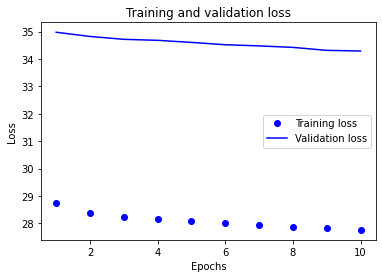

In [ ]:
entrainement_NN(NN=model_21, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_station_train, outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_model_21_build_mape = model_21.predict(X_station_test)

In [ ]:
np.mean(Y_forecast_model_21_build_mape)

0.11558614

### Expérience 22: Conv1D avec X_forecast, loss=build_MAPE

In [ ]:
def Convolution_4():
  inputs = Input(shape=(24,7), name='inputs')
  x = Conv1D(32,7, activation='relu')(inputs)
  x = MaxPooling1D(2)(x)
  x = Conv1D(32,7, activation='relu')(x)
  x = tf.keras.layers.GlobalMaxPooling1D()(x)
  outputs = Dense(1, activation='relu', name='dense_6')(x)
  return Model(inputs, outputs, name='Convolution_4')

In [ ]:
model_22 = Convolution_4()
model_22.summary()

Model: "Convolution_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 24, 7)]           0         
                                                                 
 conv1d_14 (Conv1D)          (None, 18, 32)            1600      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 9, 32)            0         
 1D)                                                             
                                                                 
 conv1d_15 (Conv1D)          (None, 3, 32)             7200      
                                                                 
 global_max_pooling1d_7 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 1)               

Epoch 1/10
594/594 [==============================] - 6s 9ms/step - loss: 24.3818 - build_MAPE: 24.3818 - val_loss: 29.0811 - val_build_MAPE: 29.0811
Epoch 2/10
594/594 [==============================] - 5s 9ms/step - loss: 23.0740 - build_MAPE: 23.0740 - val_loss: 28.9724 - val_build_MAPE: 28.9724
Epoch 3/10
594/594 [==============================] - 5s 9ms/step - loss: 22.8117 - build_MAPE: 22.8117 - val_loss: 28.7902 - val_build_MAPE: 28.7902
Epoch 4/10
594/594 [==============================] - 5s 9ms/step - loss: 22.6304 - build_MAPE: 22.6304 - val_loss: 28.8115 - val_build_MAPE: 28.8115
Epoch 5/10
594/594 [==============================] - 5s 9ms/step - loss: 22.4807 - build_MAPE: 22.4807 - val_loss: 28.7376 - val_build_MAPE: 28.7376
Epoch 6/10
594/594 [==============================] - 5s 9ms/step - loss: 22.3429 - build_MAPE: 22.3429 - val_loss: 28.7110 - val_build_MAPE: 28.7110
Epoch 7/10
594/594 [==============================] - 5s 9ms/step - loss: 22.2378 - build_MAPE: 22.2

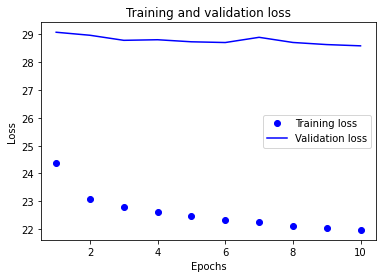

In [ ]:
entrainement_NN(NN=model_22, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_forecast_train[:,:,:-4], outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_model_22_build_mape = model_22.predict(X_forecast_test[:,:,:-4])

In [ ]:
np.mean(Y_forecast_model_22_build_mape)

0.8823561

### Expérience 23: Conv1D avec X_forecast et prédicteurs constants, loss=build_MAPE

In [ ]:
def Convolution_5():
  inputs = Input(shape=(24,11), name='inputs')
  x = Conv1D(32,7, activation='relu')(inputs)
  x = MaxPooling1D(2)(x)
  x = Conv1D(32,7, activation='relu')(x)
  x = tf.keras.layers.GlobalMaxPooling1D()(x)
  outputs = Dense(1, activation='relu', name='dense_6')(x)
  return Model(inputs, outputs, name='Convolution_5')

In [ ]:
model_23 = Convolution_5()
model_23.summary()

Model: "Convolution_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 24, 11)]          0         
                                                                 
 conv1d_16 (Conv1D)          (None, 18, 32)            2496      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 9, 32)            0         
 1D)                                                             
                                                                 
 conv1d_17 (Conv1D)          (None, 3, 32)             7200      
                                                                 
 global_max_pooling1d_8 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 1)               

Epoch 1/10
594/594 [==============================] - 7s 10ms/step - loss: 24.5517 - build_MAPE: 24.5517 - val_loss: 29.4818 - val_build_MAPE: 29.4818
Epoch 2/10
594/594 [==============================] - 6s 10ms/step - loss: 23.1043 - build_MAPE: 23.1043 - val_loss: 29.4660 - val_build_MAPE: 29.4660
Epoch 3/10
594/594 [==============================] - 6s 10ms/step - loss: 22.8302 - build_MAPE: 22.8302 - val_loss: 29.3089 - val_build_MAPE: 29.3089
Epoch 4/10
594/594 [==============================] - 6s 10ms/step - loss: 22.6278 - build_MAPE: 22.6278 - val_loss: 29.4757 - val_build_MAPE: 29.4757
Epoch 5/10
594/594 [==============================] - 5s 9ms/step - loss: 22.4687 - build_MAPE: 22.4687 - val_loss: 29.4296 - val_build_MAPE: 29.4296
Epoch 6/10
594/594 [==============================] - 5s 9ms/step - loss: 22.3216 - build_MAPE: 22.3216 - val_loss: 29.8554 - val_build_MAPE: 29.8554
Epoch 7/10
594/594 [==============================] - 5s 9ms/step - loss: 22.2093 - build_MAPE: 

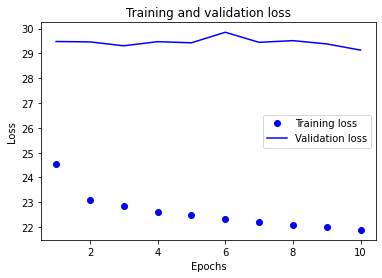

In [ ]:
entrainement_NN(NN=model_23, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_forecast_train, outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_model_23_build_mape = model_23.predict(X_forecast_test)

In [ ]:
np.mean(Y_forecast_model_23_build_mape)

0.84720075

### Expérience 24: Conv1D_2 avec X_forecast et prédicteurs constants, loss=build_MAPE

In [ ]:
def Convolution_6():
  inputs = Input(shape=(24,11), name='inputs')
  x = Conv1D(32,3, activation='relu')(inputs)
  x = MaxPooling1D(2)(x)
  x = Conv1D(32,3, activation='relu')(x)
  x = MaxPooling1D(2)(x)
  x = Conv1D(32,3, activation='relu')(x)
  x = tf.keras.layers.GlobalMaxPooling1D()(x)
  outputs = Dense(1, activation='relu', name='dense_6')(x)
  return Model(inputs, outputs, name='Convolution_6')

In [ ]:
model_24 = Convolution_6()
model_24.summary()

Model: "Convolution_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 24, 11)]          0         
                                                                 
 conv1d_23 (Conv1D)          (None, 22, 32)            1088      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 11, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_24 (Conv1D)          (None, 9, 32)             3104      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 4, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 2, 32)           

Epoch 1/10
594/594 [==============================] - 8s 12ms/step - loss: 25.5150 - build_MAPE: 25.5150 - val_loss: 29.9887 - val_build_MAPE: 29.9887
Epoch 2/10
594/594 [==============================] - 7s 11ms/step - loss: 23.4939 - build_MAPE: 23.4939 - val_loss: 30.0377 - val_build_MAPE: 30.0377
Epoch 3/10
594/594 [==============================] - 7s 11ms/step - loss: 23.0921 - build_MAPE: 23.0921 - val_loss: 30.0362 - val_build_MAPE: 30.0362
Epoch 4/10
594/594 [==============================] - 7s 11ms/step - loss: 22.8810 - build_MAPE: 22.8810 - val_loss: 29.8077 - val_build_MAPE: 29.8077
Epoch 5/10
594/594 [==============================] - 7s 11ms/step - loss: 22.7283 - build_MAPE: 22.7283 - val_loss: 29.3790 - val_build_MAPE: 29.3790
Epoch 6/10
594/594 [==============================] - 7s 11ms/step - loss: 22.6004 - build_MAPE: 22.6004 - val_loss: 29.8403 - val_build_MAPE: 29.8403
Epoch 7/10
594/594 [==============================] - 6s 11ms/step - loss: 22.4852 - build_MAP

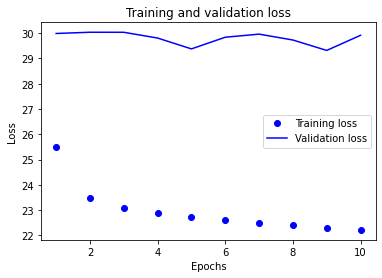

In [ ]:
entrainement_NN(NN=model_24, 
                optimizer=keras.optimizers.Adam(learning_rate = 1e-4), loss=build_MAPE, 
                inputs=X_forecast_train, outputs=Y_train, 
                epochs=10, batch_size=200)

In [ ]:
Y_forecast_model_24_build_mape = model_24.predict(X_forecast_test)

In [ ]:
np.mean(Y_forecast_model_24_build_mape)

0.8494219

Text(0.5, 1.0, 'Scores de MAPE des différents NN \n par rapport à la moyenne des prévisions')

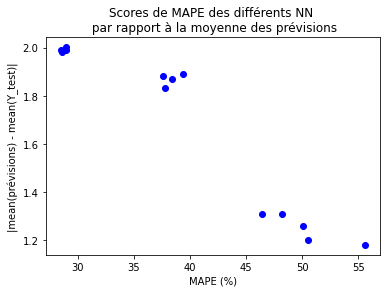

In [ ]:
MAPE = [39.4, 38.4, 37.8, 37.6, 55.6, 28.5, 28.6, 29, 29, 50.5, 48.2, 50.1, 46.4]
mean = np.array([0.24, 0.26, 0.3, 0.25, 0.95, 0.14, 0.15, 0.14, 0.13, 0.93, 0.82, 0.87, 0.82])
mean = abs(mean - np.mean(Y_test))
plt.plot(MAPE, mean, "ob")
plt.xlabel("MAPE (%)")
plt.ylabel("|mean(prévisions) - mean(Y_test)|")
plt.title("Scores de MAPE des différents NN \n par rapport à la moyenne des prévisions")

#4. Sauvegarde des prévisions de précipitations 24h de l'échantillon de test

Mise en forme du tenseur final de prévisions de précipitations cumulées sur 24h sous la forme **submission_format** exigé sur $Kaggle$.  
On effectue ainsi la liste des identifiants de l'échantillon de test final à rendre sur le *github*, sous la forme d'un *np.array* de $85140$ lignes.

In [ ]:
id_test_float[1000]

array([5.0000000e+00, 3.7055002e+07, 8.0000000e+00])

In [ ]:
# Conversion de la liste des identifiants (numéro_station__indice_jour_test) des échantillons de test du float au string.
id_test_str = []

for i in range(len(id_test_float)):
  id_test_str.append(str(int(id_test_float[i,1]))+"_"+str(int(id_test_float[i,0])))

id_test_str = np.asarray(id_test_str)

In [ ]:
id_test_str

array(['86272002_0', '14577003_0', '14066001_0', ..., '86165005_361',
       '91200002_361', '95690001_361'], dtype='<U12')

In [ ]:
# Mise en forme des prévisions de précipitations.
predictions = np.empty((85140,1))
predictions[:] = np.nan

for i in range(len(predictions)):
  id_sf = submission_format[i]
  ind = np.where(id_test_str == id_sf)[0]
  if ind.shape[0] == 1:
    n = ind[0]
    prediction = Y_forecast_test[n]
    predictions[i] = prediction

predictions += 1  # on rajoute le 1 comme demandé sur kaggle

On fois la matrice des prévisions produite pour les 85140 échantillons de la baseline_test effectuée, on effectue un remplacement des NaN afin de pouvoir être traiter sur Kaggle pour le calcul du score de MAPE.  
Pour ce faire, plusieurs options sont envisagées.  
* La première consiste à remplacer les données manquantes par la moyenne des prévisions de l'ensemble de test, soit la moyenne de la matrice.  
* La deuxième consiste juste à remplacer les NaN par des zéros.  
* La troisième consiste à remplacer les NaN par la moyenne des prévisions mensuelles de l'ensemble de test, en fonction du mois des échantillons manquants.

<u> Première approche

In [ ]:
# remplacement des NaN dans le np.array predictions par la moyenne de la matrice.
col_mean = np.nanmean(predictions, axis = 0)
inds = np.where(np.isnan(predictions))
predictions[inds] = np.take(col_mean, inds[1]) 

In [ ]:
# création du np.array de la baseline_observation de format (85140,1)
baseline = np.reshape(baseline_o[:,2], (-1,1))

In [ ]:
# calcul du score de MAPE sur l'échantillon de la baseline de test.
MAPE = round(float(100/len(baseline) * sum(np.abs((baseline+1-predictions)/(baseline+1)))), 1)  # avec meancol
print("MAPE =", MAPE, "%")

MAPE = 39.1 %


On observe une dégradation du score de MAPE, passant de (*31%*) sur notre échantillon de test **Y_test** à (*37%*) sur l'échantillon de test de la **baseline_test**.  
Cela est dû au fait que les prévisions de notre réseau de neurones n'ont pas pu être effectuées sur l'ensemble des $85140$ échantillons de la **baseline_test** mais uniquement sur $72505$ échantillons, et que des fausses valeurs ont dû être générées pour combler les échantillons manquants.

<u> Deuxième approche

In [ ]:
# remplacement des NaN dans le np.array predictions par des zéros.
col_mean = np.nanmean(predictions, axis = 0)*0 +1  # on rajoute le 1 comme demandé sur kaggle
inds = np.where(np.isnan(predictions))
predictions[inds] = np.take(col_mean, inds[1]) 

In [ ]:
# création du np.array de la baseline_observation de format (85140,1)
baseline = np.reshape(baseline_o[:,2], (-1,1))

In [ ]:
MAPE = round(float(100/len(baseline) * sum(np.abs((baseline+1-predictions)/(baseline+1)))), 1)  # avec 0
print("MAPE =", MAPE, "%")

MAPE = 41.9 %


En remplaçant les NaN par des zéros, on obtient cette fois un score de MAPE de (*42%*), ce qui est moins nettement performant que les (*31%*) en sortie de modèle, et également inférieur au même calcul de MAPE lorsque les données manquantes ont été comblées par la moyenne des prévisions.

<u> Troisième approche

In [ ]:
# calcul des moyennes mensuelles de précipitations sur l'échantillon de test $baseline_observation_test$.
precip_mensuelles_test = np.zeros((12))
nb_mensuel_test = np.zeros((12))
for i in range(len(baseline_o)):
  jour = int(baseline_o[i,1])
  mois = int(id_month_test[jour,1])
  precip_mensuelles_test[mois-1] += baseline_o[i,2]
  nb_mensuel_test[mois-1] += 1
moyennes_mensuelles_test = precip_mensuelles_test / nb_mensuel_test

In [ ]:
moyennes_mensuelles_test

array([1.95427515, 1.48342068, 2.48573657, 1.94570971, 1.52035769,
       2.50379072, 0.75844029, 1.46814434, 0.93151862, 2.82069012,
       3.8912184 , 4.3540544 ])

In [ ]:
# remplacement des NaN dans le np.array predictions par des -np.pi.
col_mean = np.nanmean(predictions, axis = 0)*0 -np.pi
inds = np.where(np.isnan(predictions))
predictions[inds] = np.take(col_mean, inds[1]) 

In [ ]:
# création du np.array de la baseline_observation de format (85140,1)
baseline = np.reshape(baseline_o[:,2], (-1,1))

In [ ]:
for i in range(len(baseline)):
  if predictions[i,0]==-np.pi:
    jour = int(baseline_o[i,1])
    mois = int(id_month_test[jour,1])
    predictions[i,0] = moyennes_mensuelles_test[mois-1] + 1 # on rajoute le 1 comme demandé sur kaggle

In [ ]:
MAPE = round(float(100/len(baseline) * sum(np.abs((baseline+1-predictions)/(baseline+1)))), 1)  # avec 0
print("MAPE =", MAPE, "%")

MAPE = 38.7 %


   
Afin d'avoir une base de prévision de référence en-dehors de la **baseline_forecast**, on choisit de calculer le score de MAPE avec à la place d'une matrice de prévisions modèle, une matrice entièrement remplie de zéros.

In [ ]:
zeros = np.zeros((85140,1))

In [ ]:
MAPE = round(float(100/len(baseline) * sum(np.abs((baseline-zeros)/(baseline+1)))), 1)  # avec meancol
print("MAPE =", MAPE, "%")

MAPE = 32.3 %


On obtient un meilleur score avec une matrice entièrement vide qu'avec une matrice remplie de prévisions générées par un modèle.  
Ce résultat met en évidence tout d'abord la pauvreté prédictive des différents réseaux de neurones que nous avons testé, mais également le manque de pertinence de l'estimateur statistique du score de MAPE pour vérifier la qualité d'un système de prévision.  
Pour une étude plus poussée, il pourrait être intéressant d'évaluer la qualité de prévision des différents réseaux de neurones testés à partir de plusieurs scores statistiques, afin de mettre en évidence plus précisément la qualité de prévision des modèles avec plusieurs attributs de qualité tels que l'acuité, la fiabilité, ou encore la résolution.  
A partir de ces différents calculs de scores, on pourrait par exemple observer une plus grande capacité prédictive globale des réseaux de neurones prenant en entrée à la fois les prévisions modèles et les observations, plutôt que de simples réseaux de neurones ne prenant en entrée qu'une seule source d'informations.

In [ ]:
# Création du fichier final de soumission des résultats du défi IA sur Kaggle.
submission_github = np.concatenate((np.reshape(submission_format, (-1,1)), predictions), axis=1)

pd.DataFrame(submission_github.reshape((len(submission_github),-1))).to_csv(path+'Rainmen.csv')

### Fonction finale

Moyennes mensuelles baseline

In [ ]:
# Conversion de la liste des identifiants (numéro_station__indice_jour_test) des échantillons de test du float au string.
id_test_str = []

for i in range(len(id_test_float)):
  id_test_str.append(str(int(id_test_float[i,1]))+"_"+str(int(id_test_float[i,0])))

id_test_str = np.asarray(id_test_str)

# calcul des moyennes mensuelles de précipitations sur l'échantillon de test $baseline_observation_test$.
precip_mensuelles_test = np.zeros((12))
nb_mensuel_test = np.zeros((12))
for i in range(len(baseline_o)):
  jour = int(baseline_o[i,1])
  mois = int(id_month_test[jour,1])
  precip_mensuelles_test[mois-1] += baseline_o[i,2]
  nb_mensuel_test[mois-1] += 1
moyennes_mensuelles_test = precip_mensuelles_test / nb_mensuel_test

In [ ]:
# Fonction Mise en forme des prévisions de précipitations.
def mise_en_forme_prediction_kaggle(Y_forecast_model):
  predictions = np.ones((85140,1)) * -np.pi
  #predictions[:] = np.nan

  #for i in range(len(predictions)):
  #  id_sf = baseline_observation[i,0]
  #  ind = np.where(id_test_str == id_sf)[0]
  #  if ind.shape[0] == 1:
  #    n = ind[0]
  #    prediction = Y_forecast_model[n]
  #    predictions[i] = prediction
  #predictions += 1  # on rajoute le 1 comme demandé sur kaggle

  # remplacement des NaN dans le np.array predictions par des -np.pi.
  #col_mean = np.nanmean(predictions, axis = 0)*0 -np.pi
  #inds = np.where(np.isnan(predictions))
  #predictions[inds] = np.take(col_mean, inds[1])
  
  # remplacement des -np.pi dans les prédictions par les moyennes mensuelles
  for i in range(len(baseline_o)):
    if predictions[i,0]==-np.pi:
      jour = int(baseline_o[i,1])
      mois = int(id_month_test[jour,1])
      predictions[i,0] = moyennes_mensuelles_test[mois-1] + 1 # on rajoute le 1 comme demandé sur kaggle

  # Création du fichier final de soumission des résultats du défi IA sur Kaggle.
  submission_github = np.concatenate((np.reshape(baseline_observation[:,0], (-1,1)), predictions), axis=1)

  pd.DataFrame(submission_github.reshape((len(submission_github),-1))).to_csv(path+'prévisions_modèle/moy_mensuelles/climato_baseline.csv')

  print('C\'est fait !')

In [ ]:
# Exemple
mise_en_forme_prediction_kaggle(Y_forecast_model_24_build_mape)


C'est fait !


zéros

In [ ]:
# Fonction Mise en forme des prévisions de précipitations.
def mise_en_forme_prediction_kagglev2(Y_forecast_model):
  predictions = np.empty((85140,1))
  predictions[:] = np.nan

  for i in range(len(predictions)):
    id_sf = baseline_observation[i,0]
    ind = np.where(id_test_str == id_sf)[0]
    if ind.shape[0] == 1:
      n = ind[0]
      prediction = Y_forecast_model[n]
      predictions[i] = prediction
  predictions += 1  # on rajoute le 1 comme demandé sur kaggle

  # remplacement des NaN dans le np.array predictions des zéros.
  col_mean = np.nanmean(predictions, axis = 0)*0 +1
  inds = np.where(np.isnan(predictions))
  predictions[inds] = np.take(col_mean, inds[1])
  
  # Création du fichier final de soumission des résultats du défi IA sur Kaggle.
  submission_github = np.concatenate((np.reshape(baseline_observation[:,0], (-1,1)), predictions), axis=1)

  pd.DataFrame(submission_github.reshape((len(submission_github),-1))).to_csv(path+'prévisions_modèle/zéros/Y_forecast_model_26_build_mape_zeros.csv',index=False,header = ['Id','Prediction'])

  print('C\'est fait !')

In [ ]:
# Exemple
mise_en_forme_prediction_kagglev2(Y_forecast_model_26_build_mape)

C'est fait !


In [ ]:
moyenne_4_modeles = Y_forecast_model_23_build_mape + Y_forecast_model_12_build_mape + Y_forecast_model_13_5_build_mape + Y_forecast_model_18_build_mape
moyenne_4_modeles = moyenne_4_modeles / 4

In [ ]:
np.mean(moyenne_4_modeles)

0.8488895

In [ ]:
super_moyenne = Y_forecast_model_1_3_build_mape + Y_forecast_model_2_2_build_mape + Y_forecast_model_3_2_build_mape + Y_forecast_model_4_2_build_mape + Y_forecast_model_5_build_mape + Y_forecast_model_6_build_mape + Y_forecast_model_7_2_build_mape + Y_forecast_model_8_1_build_mape + Y_forecast_model_9_1_build_mape + Y_forecast_model_10_1_build_mape + Y_forecast_model_11_2_build_mape + Y_forecast_model_12_build_mape + Y_forecast_model_13_5_build_mape + Y_forecast_model_14_2_build_mape + Y_forecast_model_15_build_mape + Y_forecast_model_16_build_mape + Y_forecast_model_17_build_mape + Y_forecast_model_18_build_mape + Y_forecast_model_19_build_mape + Y_forecast_model_20_build_mape + Y_forecast_model_21_build_mape + Y_forecast_model_22_build_mape + Y_forecast_model_23_build_mape + Y_forecast_model_24_build_mape
super_moyenne = super_moyenne / 24

In [ ]:
np.mean(super_moyenne)

0.60267156

In [ ]:
Y_forecast_model_18_build_mape.shape

(72505, 1)

In [ ]:
zeros = np.zeros((72505,1))